# Transfomer(年齢予測)

## import ライブラリー

In [1]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from scipy.stats import pearsonr
from scipy.stats import norm

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

1

## Data定義

In [3]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3.23 s, sys: 203 ms, total: 3.44 s
Wall time: 3.47 s


In [4]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx_sex = col.index('Sex')
            if data[idx_sex] == '男':
                data[idx_sex] = 0
            else:
                data[idx_sex] = 1
        
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    if 'Age' in col:
        idx_age = col.index('Age')
    for i in range(len(col)):
        if i == idx_age:
            subjects_info[:,i] = (subjects_info[:,i] - \
                                  np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [5]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

age_mean = df_subjects_info.Age.mean()
age_std = df_subjects_info.Age.std()

CPU times: user 10.1 s, sys: 17.9 ms, total: 10.1 s
Wall time: 10.1 s


In [6]:
data_label.shape
data_aal.shape
data_ho.shape

(615, 3)

(615, 140, 116)

(615, 140, 110)

In [7]:
#30秒ぐらいかかる
#data_dynamic_aal = make_data(df_dynamic_aal)
#data_dynamic_ho = make_data(df_dynamic_ho)

#data_dynamic_aal.shape
#data_dynamic_ho.shape

## Model作成

In [8]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())

In [9]:
"""class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 d_model,
                 hidden_dim,
                 time_len,
                 nhead,
                 output_dim,
                 hidden_dim_transformer,
                 pos_drop,
                 trans_drop,
                 fc_drop
                ):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,d_model)
        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc_age1  = nn.Linear(d_model,1)
        self.fc_sex1  = nn.Linear(d_model,1)
        self.fc_age2  = nn.Linear(time_len,1)
        self.fc_sex2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(fc_drop)
        self.time_len = time_len
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        age = self.fc_age1(x)
        sex = self.fc_sex1(x)
        
        age = self.drop(age)
        sex = self.drop(sex)
        
        age = torch.reshape(age, (-1, self.time_len))
        sex = torch.reshape(sex, (-1, self.time_len))
        
        age = self.fc_age2(age)
        sex = self.fc_sex2(sex)
        sex = self.sigmoid(sex)
        return age,sex"""

'class Model(nn.Module):    \n    def __init__(self,\n                 input_dim,\n                 d_model,\n                 hidden_dim,\n                 time_len,\n                 nhead,\n                 output_dim,\n                 hidden_dim_transformer,\n                 pos_drop,\n                 trans_drop,\n                 fc_drop\n                ):\n        super(Model, self).__init__()\n        self.fc0  = nn.Linear(input_dim,d_model)\n        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)\n        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,\n                                                                    nhead,\n                                                                    dropout=trans_drop,\n                                                                    dim_feedforward=hidden_dim,\n                                                                    batch_first=True)\n        self.transformer_encoder       

In [10]:
class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 d_model,
                 hidden_dim,
                 time_len,
                 nhead,
                 output_dim,
                 hidden_dim_transformer,
                 pos_drop,
                 trans_drop,
                 fc_drop
                ):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,d_model)
        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc_age1  = nn.Linear(d_model,1)
        self.fc_sex1  = nn.Linear(d_model,1)
        self.fc_age2  = nn.Linear(time_len,1)
        #self.fc_sex2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(fc_drop)
        self.time_len = time_len
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        age = self.fc_age1(x)
        sex = self.fc_sex1(x)
        age = self.drop(age)
        sex = self.drop(sex)
        
        age = torch.reshape(age, (-1, self.time_len))
        sex = torch.reshape(sex, (-1, self.time_len))
        
        age = self.fc_age2(age)
        sex = torch.mean(sex,axis=1)
        
        sex = torch.reshape(sex, (-1, 1))
        sex = self.sigmoid(sex)
        return age,sex

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

In [12]:
def compute_loss_age(y, t):
    criterion = nn.MSELoss()
    return criterion(y, t)

def compute_loss_sex(y, t):
    criterion = nn.BCELoss()
    return criterion(y, t)

def train_step(x,t,model,optimizer):
    model.train()
    preds_age,preds_sex = model(x)
    age = t[:,0:1]
    sex = t[:,1:]
    loss_age = compute_loss_age(preds_age, age)
    loss_sex = compute_loss_sex(preds_sex, sex)
    loss = (4/5) * loss_age + (1/4) * loss_sex
    #loss = (9/10) * loss_age + (1/10) * loss_sex
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds_age, preds_sex

def val_step(x,t,model):
    model.eval()
    preds_age,preds_sex = model(x)
    age = t[:,0:1]
    sex = t[:,1:]
    loss_age = compute_loss_age(preds_age, age)
    loss_sex = compute_loss_sex(preds_sex, sex)
    loss = (4/5) * loss_age + (1/4) * loss_sex
    #loss = (9/10) * loss_age + (1/10) * loss_sex
    
    return loss, preds_age, preds_sex

def test_step(x,model):
    model.eval()
    preds_age,preds_sex = model(x)
    return preds_age, preds_sex

def seed_worker(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [13]:
def train_model(data,
                label,
                train_idx,
                test_idx,
                n_splits,
                epochs     = 750,
                d_model    = 128,
                hidden_dim = 512,
                nhead      = 32,
                hidden_dim_transformer = 2,
                pos_drop    = 0.1,
                trans_drop = 0.1,
                fc_drop = 0.1,
                title = ''
                ):
    
    epochs = epochs
    seed_worker()
    label = label[:,0:2]

    train_all = data[train_idx]
    test  = data[test_idx]
    
    train_label_all = label[train_idx]
    test_label  = label[test_idx]
    
    input_dim  = data.shape[2]
    time_len   = data.shape[1]
    output_dim = data_label.shape[1]
    d_model    = d_model
    hidden_dim = hidden_dim
    nhead      = nhead
    hidden_dim_transformer = hidden_dim_transformer
    pos_drop    = pos_drop
    trans_drop = trans_drop
    fc_drop = fc_drop
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    kf = KFold(n_splits=n_splits,shuffle=False)
    test_pred_all = []
    test_pred_all_inverse = []
    
    for i, (train_index, val_index) in enumerate(kf.split(train_all)):
        
        early_stopping = 1e5
        save_epochs = 0
        
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_label_all[train_index]
        val,   val_label   = train_all[val_index],   train_label_all[val_index]
        
        train_dataset    = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

        val_dataset      = MyDataset(val,val_label)
        val_dataloader   = torch.utils.data.DataLoader(val_dataset,batch_size=32)
        
        model = Model(input_dim = input_dim,
                      d_model  = d_model,
                      hidden_dim = hidden_dim,
                      time_len = time_len,
                      nhead = nhead,
                      output_dim = output_dim,
                      hidden_dim_transformer = hidden_dim_transformer,
                      pos_drop = pos_drop,
                      trans_drop = trans_drop,
                      fc_drop = fc_drop
                     ).to(device)
        
        optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.

            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds_age, preds_sex = train_step(x,t,model,optimizer)
                train_loss += loss.item()
            train_loss /= len(train_dataloader)
            
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds_age, preds_sex = val_step(x,t,model)
                val_loss += loss.item()
            val_loss /= len(val_dataloader)
            
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {i+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
            
            if epoch+1 >= 250:
                if early_stopping >= val_loss:
                    early_stopping = val_loss
                    model_path = '../02_data_analysis/model/model_.pth'
                    torch.save(model.state_dict(), model_path)
                    save_epochs = epoch+1
        
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        model.load_state_dict(torch.load(model_path))
        print(f'save_epochs:{save_epochs}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.figure(figsize=(6, 4), dpi=80)
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.title('Loss Curves' + ' ' + title, fontsize=14)   # 図のタイトル
        plt.xlabel('Epochs',fontsize=14) # x軸のラベル
        plt.ylabel('MSELoss',fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()

        train_pred_age = []
        train_pred_sex = []
        train_label = []
        
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds_age, preds_sex= val_step(x,t,model)
            train_pred_age.append(preds_age)
            train_pred_sex.append(preds_sex)
            train_label.append(t)
        
        val_pred_age = []
        val_pred_sex = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds_age, preds_sex= val_step(x,t,model)
            val_pred_age.append(preds_age)
            val_pred_sex.append(preds_sex)
        
        train_pred_age = torch.cat(train_pred_age)
        train_pred_age = train_pred_age.to('cpu').detach().numpy().copy()
        train_pred_sex = torch.cat(train_pred_sex)
        train_pred_sex = train_pred_sex.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred_age = torch.cat(val_pred_age)
        val_pred_age = val_pred_age.to('cpu').detach().numpy().copy()
        val_pred_sex = torch.cat(val_pred_sex)
        val_pred_sex = val_pred_sex.to('cpu').detach().numpy().copy()
        
        new_line = '\n'
        
        corr,p = pearsonr(train_label[:,0],np.array(train_pred_age[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((train_label[:,0]*age_std)+age_mean,(np.array(train_pred_age[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter train', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 train data: ', r2_score(train_label[:,0],np.array(train_pred_age[:,0])))
        
        corr,p = pearsonr(val_label[:,0],np.array(val_pred_age[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((val_label[:,0]*age_std)+age_mean,(np.array(val_pred_age[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter val', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 val data: ', r2_score(val_label[:,0],np.array(val_pred_age[:,0])))
        
        acc = 0
        for i,c in enumerate(train_label[:,1]):
            if c == 1:
                if train_pred_sex[:,0][i] >= 0.5:
                    acc += 1
            else:
                if train_pred_sex[:,0][i] < 0.5:
                    acc += 1
        q = 1/2
        n = len(train_label[:,1])
        z = (acc - n*q)/np.sqrt(n*q*(1-q))
        p = norm.sf(z)
        acc = acc/len(train_label[:,1])
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(train_label[:,1],train_pred_sex[:,0],
                   label = f'train accuracy : {acc:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'sex train', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological sex', fontsize=14) # x軸のラベル
        plt.ylabel('predicted probability', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        
        acc = 0
        for i,c in enumerate(val_label[:,1]):
            if c == 1:
                if val_pred_sex[:,0][i] >= 0.5:
                    acc += 1
            else:
                if val_pred_sex[:,0][i] < 0.5:
                    acc += 1
        q = 1/2
        n = len(val_label[:,1])
        z = (acc - n*q)/np.sqrt(n*q*(1-q))
        p = norm.sf(z)
        acc = acc/len(val_label[:,1])
                    
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,1],val_pred_sex[:,0],
                   label = f'val accuracy : {acc:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'sex val', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological sex', fontsize=14) # x軸のラベル
        plt.ylabel('predicted probability', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        
        lr = LinearRegression()
        lr.fit(val_label[:,0:1]*age_std+age_mean,val_pred_age[:,0]*age_std+age_mean)
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,0]*age_std+age_mean,val_pred_age[:,0]*age_std+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')#散布図をプロット
        plt.plot(val_label[:,0]*age_std + age_mean,
                 lr.predict(val_label[:,0:1]*age_std+age_mean), color = 'red',#回帰直線をプロット
                label = f'y = {lr.coef_[0]:.3f}x + {lr.intercept_:.3f}')#回帰直線をプロット
        
        plt.title(title + ' ' + 'val', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()  # グリッド線を表示
        plt.show()  # 図の表示
        print('切片:', lr.intercept_)
        print('傾き:', lr.coef_[0])
                
        test_pred_age = []
        test_pred_sex = []
        
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds_age, preds_sex = test_step(x,model)
            test_pred_age.append(preds_age)
            test_pred_sex.append(preds_sex)
        test_pred_age = torch.cat(test_pred_age)
        test_pred_sex = torch.cat(test_pred_sex)
        test_pred_age = test_pred_age.to('cpu').detach().numpy().copy()
        test_pred_sex = test_pred_sex.to('cpu').detach().numpy().copy()
        test_pred_age_inverse = test_pred_age * (1 / lr.coef_[0])
        test_pred     = np.concatenate([test_pred_age, test_pred_sex],1)
        test_pred_all.append(test_pred)
        test_pred_inverse  = np.concatenate([test_pred_age_inverse, test_pred_sex],1)
        test_pred_all_inverse.append(test_pred_inverse)
        
    return np.array(test_pred_all),np.array(test_pred_all_inverse),test_label

In [15]:
n_splits = 5

## 学習(AAL)

### Bold 1

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.5430384094898517, val loss: 0.7738947570323944
Kfold: 1 ::: epoch: 200, loss: 0.29182010889053345, val loss: 0.7179925441741943
Kfold: 1 ::: epoch: 300, loss: 0.23047353098025689, val loss: 0.7610132396221161
Kfold: 1 ::: epoch: 400, loss: 0.20606649838961089, val loss: 0.6873050630092621
Kfold: 1 ::: epoch: 500, loss: 0.19836981709186846, val loss: 0.7053470462560654
Kfold: 1 ::: epoch: 600, loss: 0.1810130408177009, val loss: 0.6666772961616516
Kfold: 1 ::: epoch: 700, loss: 0.1403953541929905, val loss: 0.6904627531766891
Kfold: 1 ::: epoch: 800, loss: 0.06894248580703369, val loss: 0.7550616711378098
Kfold: 1 ::: epoch: 900, loss: 0.03378717415034771, val loss: 0.9189378023147583
Kfold: 1 ::: epoch: 1000, loss: 0.02709471319730465, val loss: 1.0397435873746872
save_epochs:609


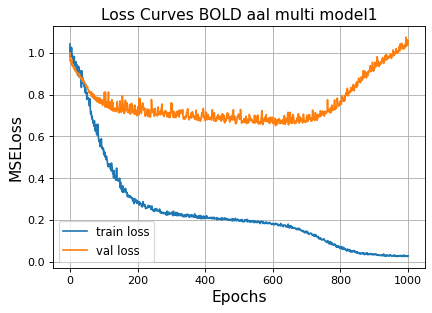

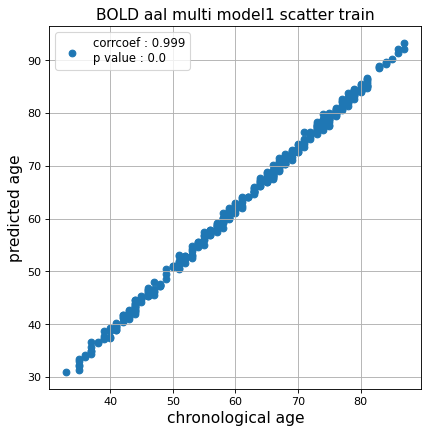

r^2 train data:  0.9461787596955421


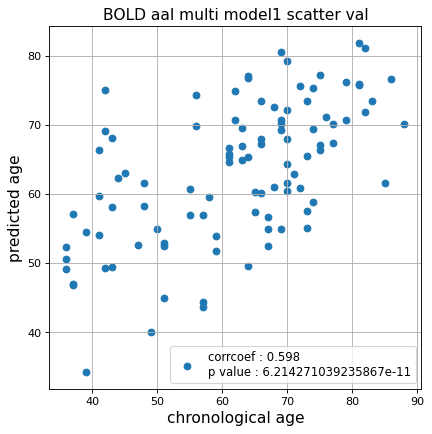

r^2 val data:  0.33056387147489674


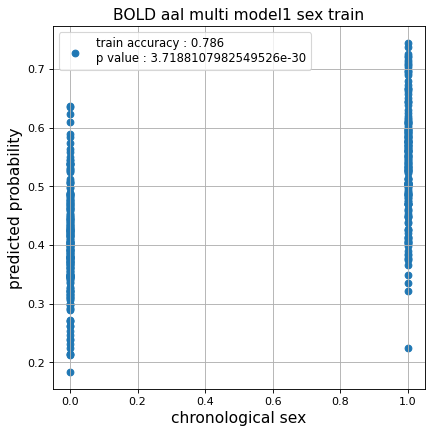

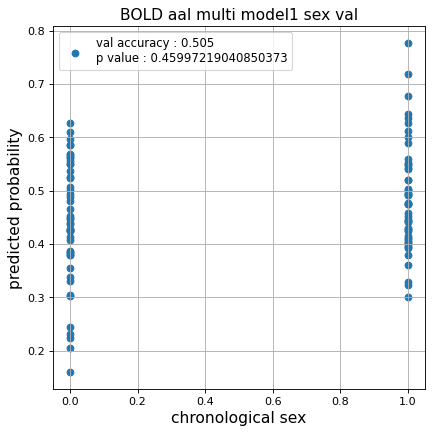

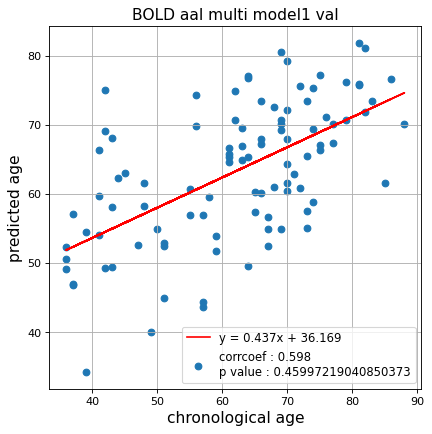

切片: 36.16920090766767
傾き: 0.4374169009707994
Kfold: 2 ::: epoch: 100, loss: 0.5556172957787147, val loss: 0.9015809297561646
Kfold: 2 ::: epoch: 200, loss: 0.29400728986813474, val loss: 0.8349391520023346
Kfold: 2 ::: epoch: 300, loss: 0.25377678871154785, val loss: 0.800035685300827
Kfold: 2 ::: epoch: 400, loss: 0.23587879653160387, val loss: 0.7861807942390442
Kfold: 2 ::: epoch: 500, loss: 0.20795507155931914, val loss: 0.7556091398000717
Kfold: 2 ::: epoch: 600, loss: 0.18821187202747053, val loss: 0.7233728915452957
Kfold: 2 ::: epoch: 700, loss: 0.15686809328886178, val loss: 0.7060476392507553
Kfold: 2 ::: epoch: 800, loss: 0.07969019504693839, val loss: 0.7513411045074463
Kfold: 2 ::: epoch: 900, loss: 0.0365662187910997, val loss: 0.8365649282932281
Kfold: 2 ::: epoch: 1000, loss: 0.029843435980952703, val loss: 0.8743277937173843
save_epochs:730


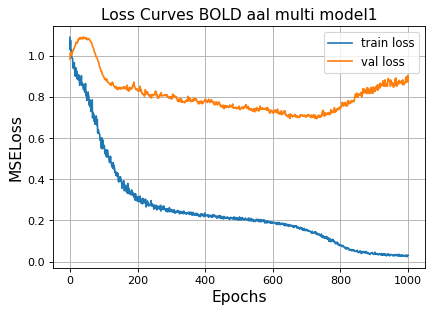

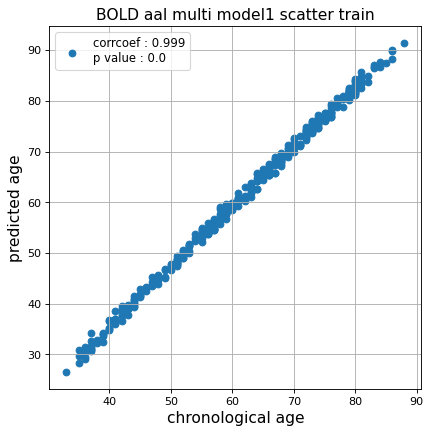

r^2 train data:  0.9633730192682863


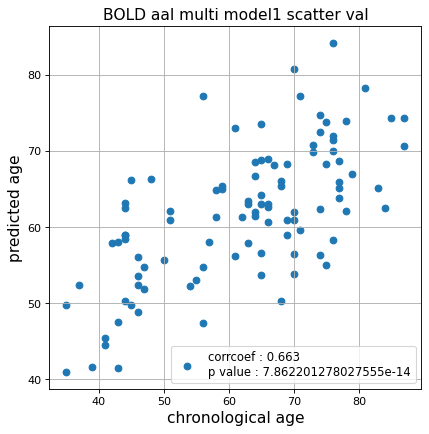

r^2 val data:  0.438825006824624


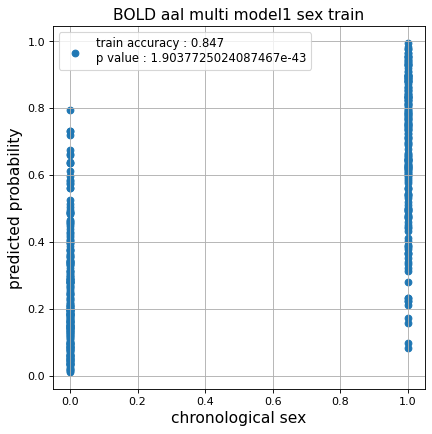

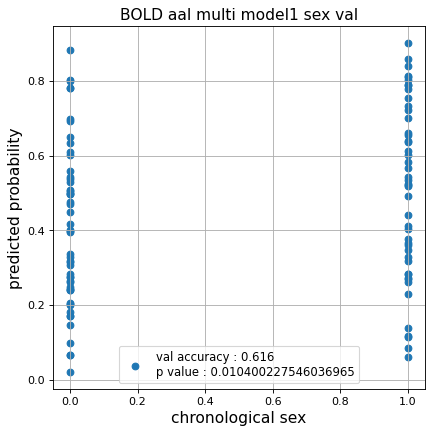

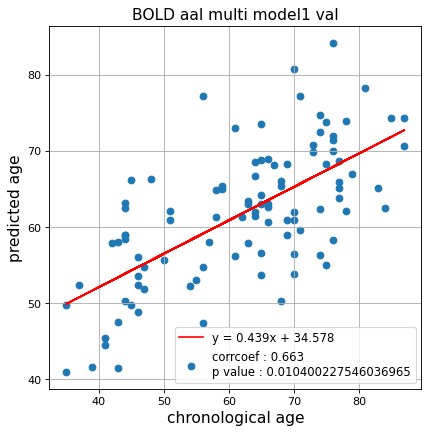

切片: 34.578160547896005
傾き: 0.4387729195293765
Kfold: 3 ::: epoch: 100, loss: 0.6067084761766287, val loss: 0.9078540503978729
Kfold: 3 ::: epoch: 200, loss: 0.2996457517147064, val loss: 0.8405586928129196
Kfold: 3 ::: epoch: 300, loss: 0.23851818190171167, val loss: 0.8369721993803978
Kfold: 3 ::: epoch: 400, loss: 0.22172664220516497, val loss: 0.8120234981179237
Kfold: 3 ::: epoch: 500, loss: 0.19942563542952904, val loss: 0.7992277219891548
Kfold: 3 ::: epoch: 600, loss: 0.16984738868016463, val loss: 0.7928616404533386
Kfold: 3 ::: epoch: 700, loss: 0.10996468709065364, val loss: 0.7954690977931023
Kfold: 3 ::: epoch: 800, loss: 0.05452265217900276, val loss: 0.8984805941581726
Kfold: 3 ::: epoch: 900, loss: 0.034793587114948496, val loss: 0.9674080610275269
Kfold: 3 ::: epoch: 1000, loss: 0.027303397942047853, val loss: 0.9802227020263672
save_epochs:612


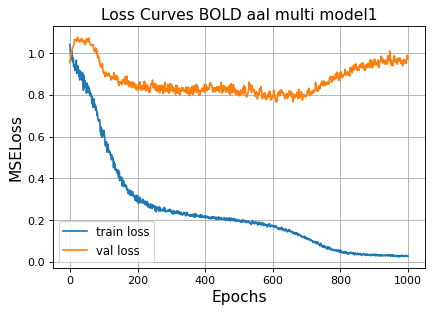

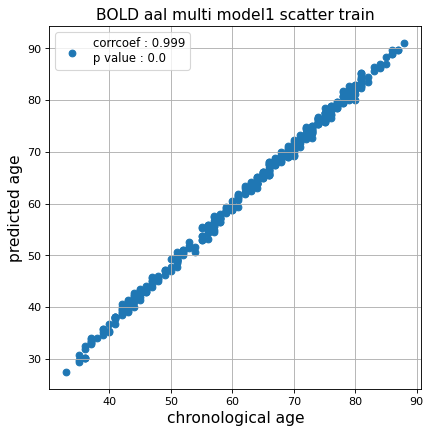

r^2 train data:  0.9756074821647552


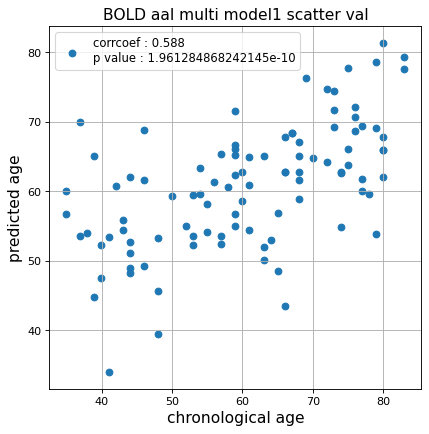

r^2 val data:  0.34035028168064374


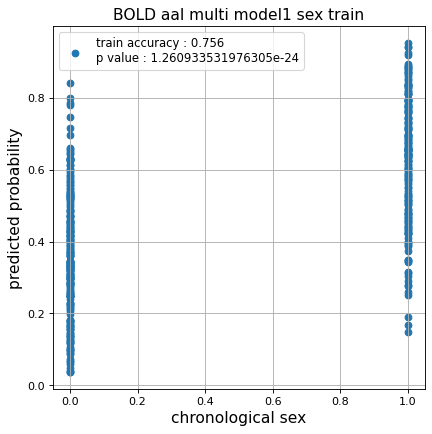

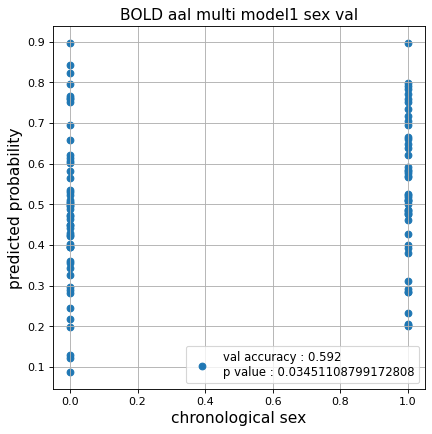

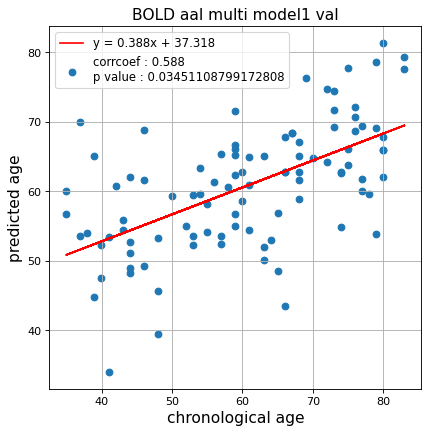

切片: 37.31764233302073
傾き: 0.38750444444788695
Kfold: 4 ::: epoch: 100, loss: 0.5170661692435925, val loss: 1.3740097433328629
Kfold: 4 ::: epoch: 200, loss: 0.29901848618800825, val loss: 1.3573966324329376
Kfold: 4 ::: epoch: 300, loss: 0.2326015062057055, val loss: 1.3400309830904007
Kfold: 4 ::: epoch: 400, loss: 0.21245432702394632, val loss: 1.3161257654428482
Kfold: 4 ::: epoch: 500, loss: 0.19543221936776087, val loss: 1.2808378487825394
Kfold: 4 ::: epoch: 600, loss: 0.18109109883125013, val loss: 1.2481461018323898
Kfold: 4 ::: epoch: 700, loss: 0.1478814843755502, val loss: 1.2412619292736053
Kfold: 4 ::: epoch: 800, loss: 0.09272708915747128, val loss: 1.3455712050199509
Kfold: 4 ::: epoch: 900, loss: 0.03614933158342655, val loss: 1.4711298793554306
Kfold: 4 ::: epoch: 1000, loss: 0.025434056440225013, val loss: 1.5432972311973572
save_epochs:671


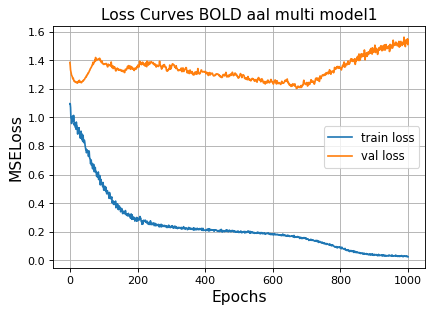

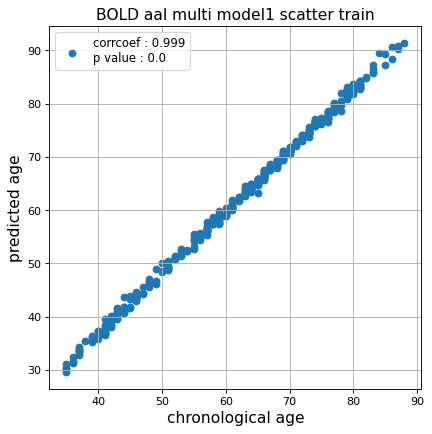

r^2 train data:  0.9761458634079112


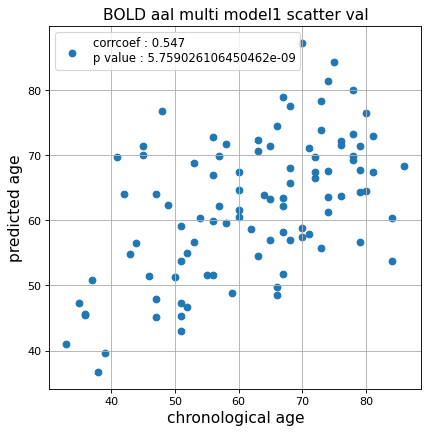

r^2 val data:  0.23685008383172357


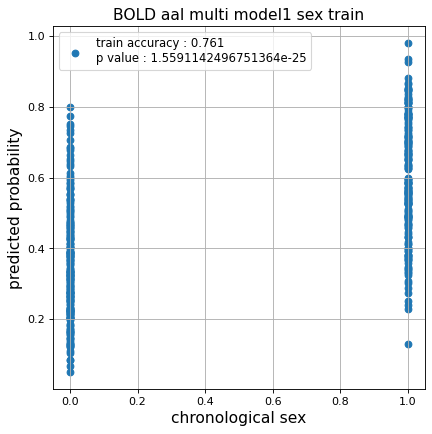

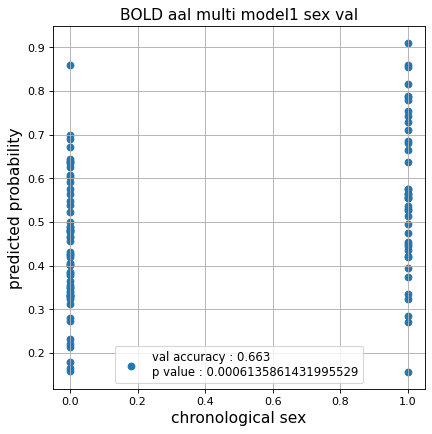

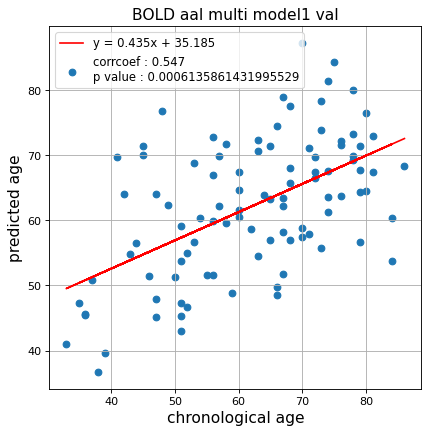

切片: 35.18523599830769
傾き: 0.43492086202096697
Kfold: 5 ::: epoch: 100, loss: 0.5046674471635085, val loss: 0.9617474228143692
Kfold: 5 ::: epoch: 200, loss: 0.281216752070647, val loss: 0.8957632780075073
Kfold: 5 ::: epoch: 300, loss: 0.2312575922562526, val loss: 0.8782529383897781
Kfold: 5 ::: epoch: 400, loss: 0.2102201133966446, val loss: 0.8601451516151428
Kfold: 5 ::: epoch: 500, loss: 0.19652857803381407, val loss: 0.8345100581645966
Kfold: 5 ::: epoch: 600, loss: 0.16245063910117516, val loss: 0.7972961515188217
Kfold: 5 ::: epoch: 700, loss: 0.09904477172172986, val loss: 0.8331531547009945
Kfold: 5 ::: epoch: 800, loss: 0.040455032856418535, val loss: 0.9316074699163437
Kfold: 5 ::: epoch: 900, loss: 0.02886519867640275, val loss: 0.9887271523475647
Kfold: 5 ::: epoch: 1000, loss: 0.02864667823394904, val loss: 1.0407266914844513
save_epochs:662


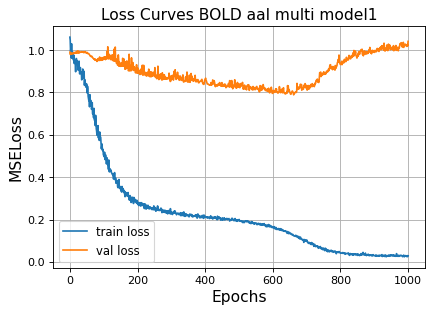

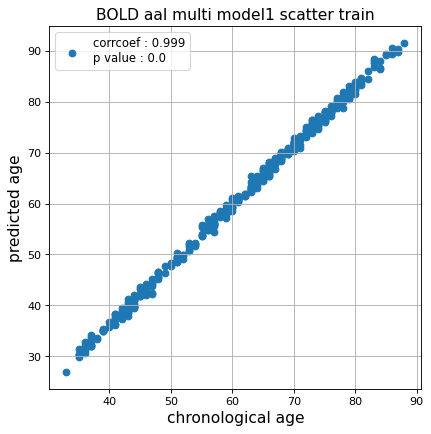

r^2 train data:  0.9672877317639049


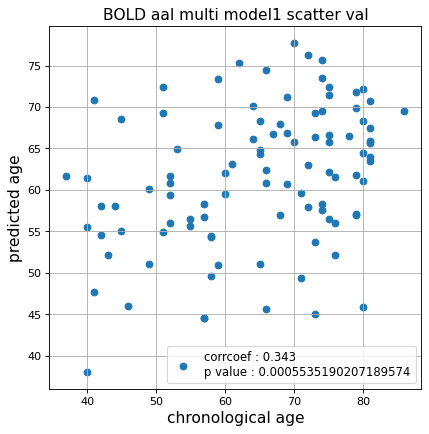

r^2 val data:  -0.04048275143341562


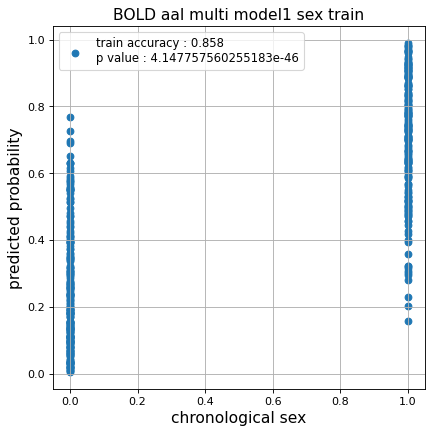

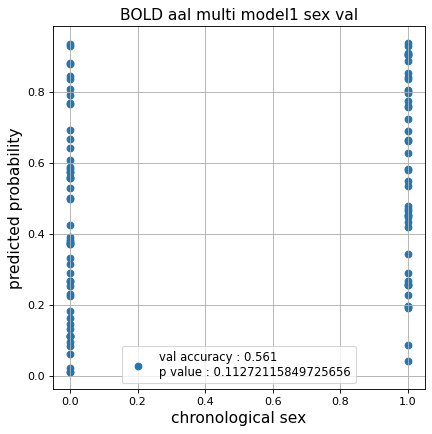

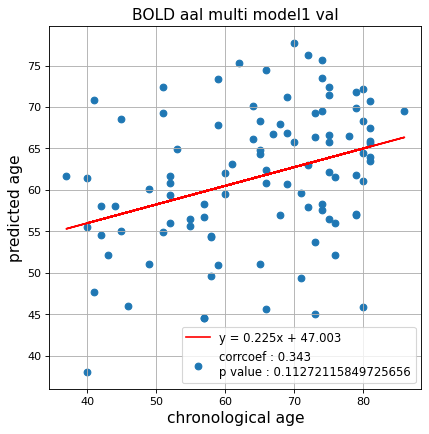

切片: 47.00273172177933
傾き: 0.2248503215014919
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.5386523994115683, val loss: 0.6748064681887627
Kfold: 1 ::: epoch: 200, loss: 0.28265880850645214, val loss: 0.6389144584536552
Kfold: 1 ::: epoch: 300, loss: 0.23020611244898576, val loss: 0.6199954599142075
Kfold: 1 ::: epoch: 400, loss: 0.20815697541603675, val loss: 0.6304767355322838
Kfold: 1 ::: epoch: 500, loss: 0.1994854177419956, val loss: 0.6172411739826202
Kfold: 1 ::: epoch: 600, loss: 0.17670723681266493, val loss: 0.6305480748414993
Kfold: 1 ::: epoch: 700, loss: 0.13700385907521614, val loss: 0.6074224784970284
Kfold: 1 ::: epoch: 800, loss: 0.06724434833113964, val loss: 0.6455904543399811
Kfold: 1 ::: epoch: 900, loss: 0.03330929777943171, val loss: 0.7274343371391296
Kfold: 1 ::: epoch: 1000, loss: 0.024185331968160775, val loss: 0.76918725669384
save_epochs:659


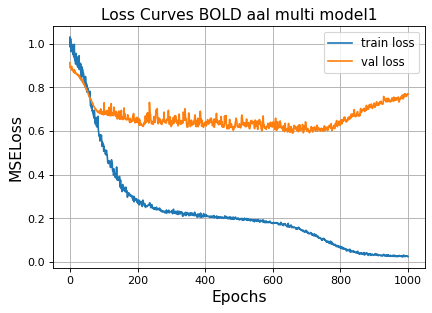

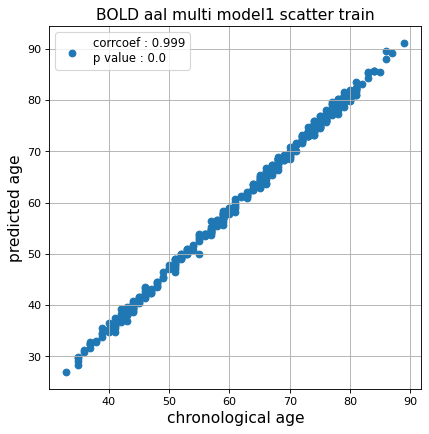

r^2 train data:  0.9658963405726458


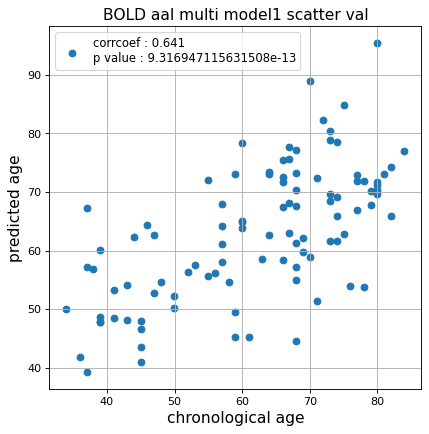

r^2 val data:  0.36926617923491456


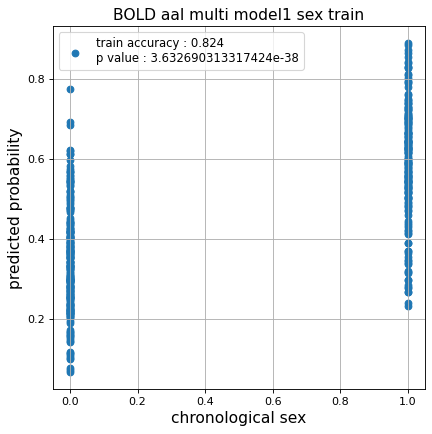

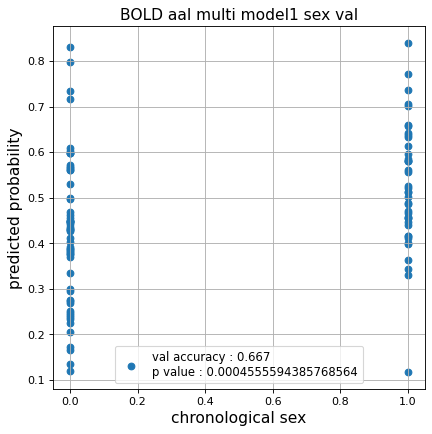

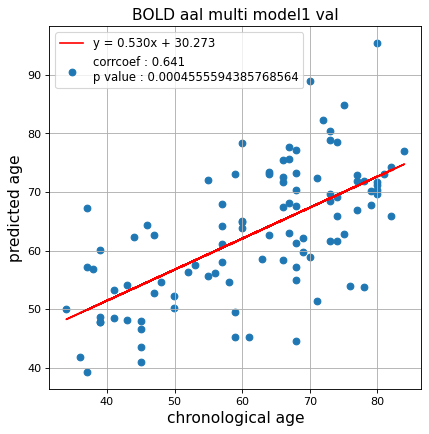

切片: 30.27276318118362
傾き: 0.5295585998555659
Kfold: 2 ::: epoch: 100, loss: 0.5703630584936875, val loss: 1.0127464830875397
Kfold: 2 ::: epoch: 200, loss: 0.29903473074619585, val loss: 0.9314471185207367
Kfold: 2 ::: epoch: 300, loss: 0.24815102609304282, val loss: 0.8864097595214844
Kfold: 2 ::: epoch: 400, loss: 0.23174676872216737, val loss: 0.8700818717479706
Kfold: 2 ::: epoch: 500, loss: 0.2050498013313, val loss: 0.8144173920154572
Kfold: 2 ::: epoch: 600, loss: 0.18406914403805366, val loss: 0.8045080751180649
Kfold: 2 ::: epoch: 700, loss: 0.1464592361679444, val loss: 0.7654922008514404
Kfold: 2 ::: epoch: 800, loss: 0.07399391411588742, val loss: 0.8448167592287064
Kfold: 2 ::: epoch: 900, loss: 0.03178207619258991, val loss: 0.9392646253108978
Kfold: 2 ::: epoch: 1000, loss: 0.03239588432300549, val loss: 0.984708309173584
save_epochs:702


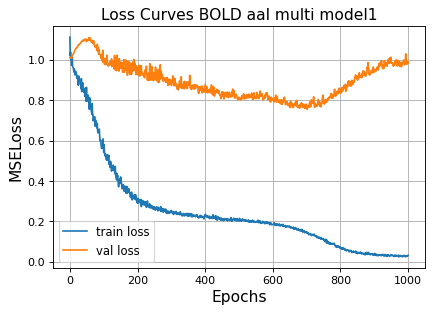

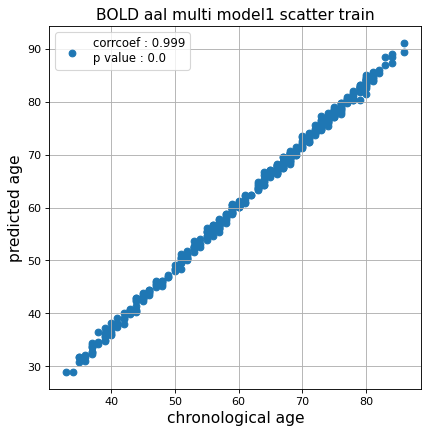

r^2 train data:  0.9662109041346351


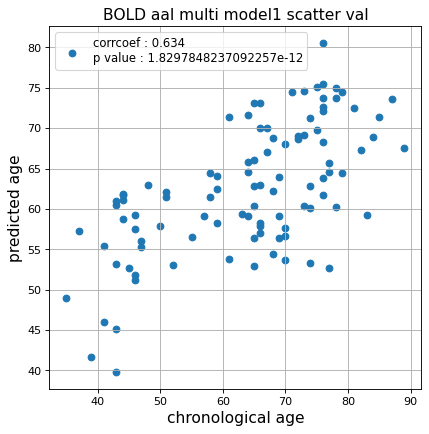

r^2 val data:  0.39042994880484017


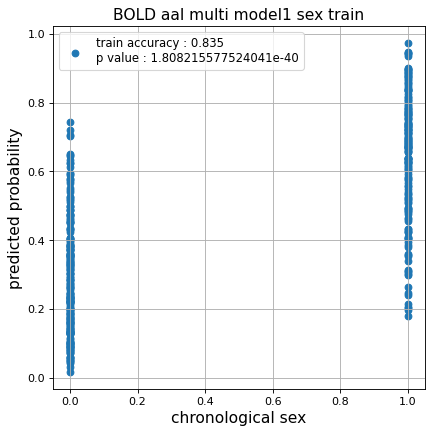

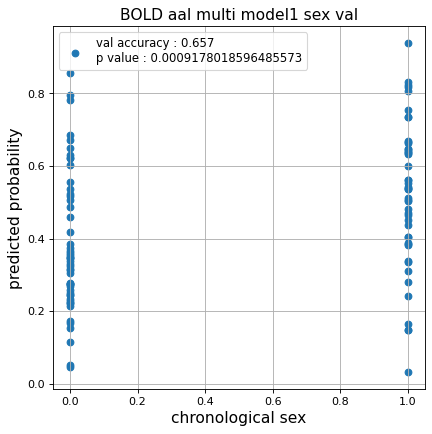

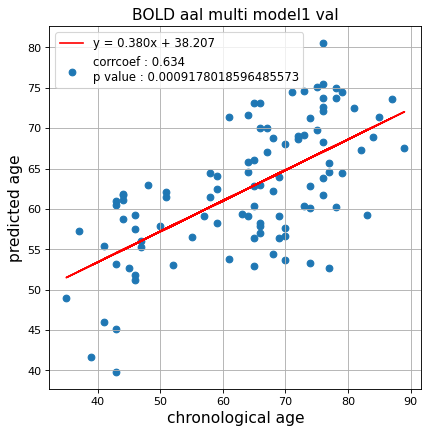

切片: 38.20746395359383
傾き: 0.3798950020959588
Kfold: 3 ::: epoch: 100, loss: 0.6072287146861737, val loss: 0.9365496784448624
Kfold: 3 ::: epoch: 200, loss: 0.3140229147214156, val loss: 0.885561004281044
Kfold: 3 ::: epoch: 300, loss: 0.23186614307073447, val loss: 0.8463244587182999
Kfold: 3 ::: epoch: 400, loss: 0.2127843820131742, val loss: 0.7957727015018463
Kfold: 3 ::: epoch: 500, loss: 0.18657322571827814, val loss: 0.7811454236507416
Kfold: 3 ::: epoch: 600, loss: 0.1469092036669071, val loss: 0.8002234101295471
Kfold: 3 ::: epoch: 700, loss: 0.07684566882940438, val loss: 0.8148161917924881
Kfold: 3 ::: epoch: 800, loss: 0.04503850624538385, val loss: 0.8696364909410477
Kfold: 3 ::: epoch: 900, loss: 0.03474674932658672, val loss: 0.9524419009685516
Kfold: 3 ::: epoch: 1000, loss: 0.027003510353656914, val loss: 0.9559918493032455
save_epochs:596


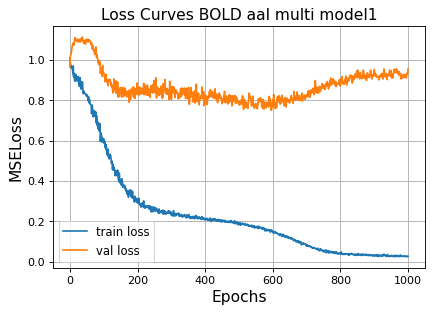

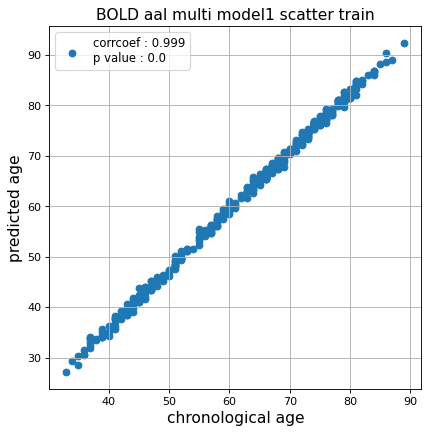

r^2 train data:  0.9693822886673846


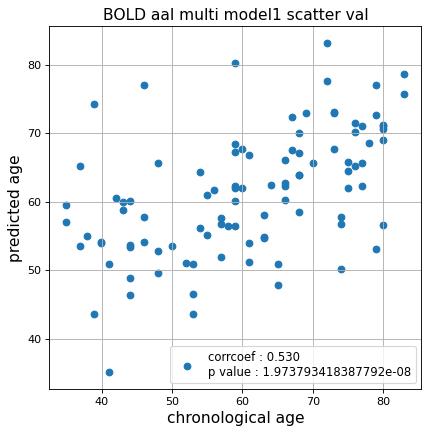

r^2 val data:  0.25844619041333816


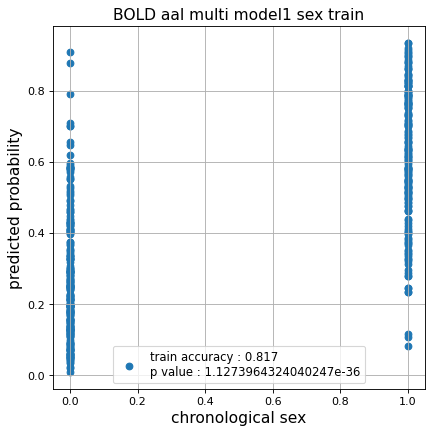

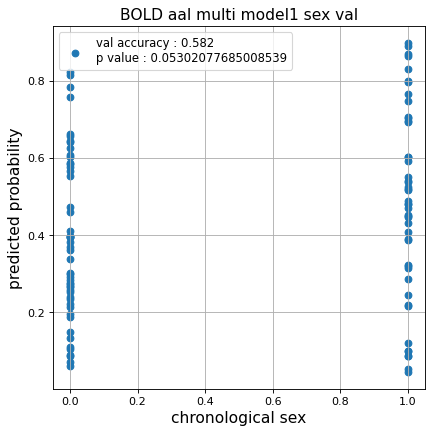

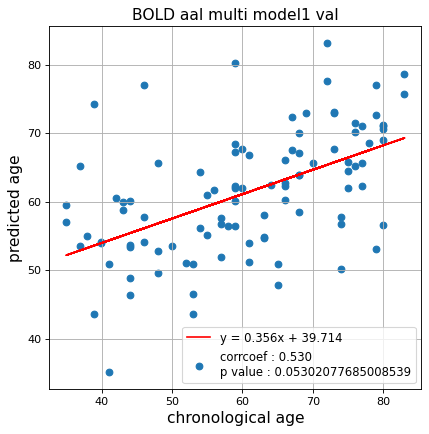

切片: 39.713735351743594
傾き: 0.35622364517642796
Kfold: 4 ::: epoch: 100, loss: 0.5409890573758346, val loss: 1.26130910217762
Kfold: 4 ::: epoch: 200, loss: 0.2948808830517989, val loss: 1.3072091788053513
Kfold: 4 ::: epoch: 300, loss: 0.22589520536936247, val loss: 1.3555231988430023
Kfold: 4 ::: epoch: 400, loss: 0.21187526675371024, val loss: 1.3611464649438858
Kfold: 4 ::: epoch: 500, loss: 0.20025374797674325, val loss: 1.3655923902988434
Kfold: 4 ::: epoch: 600, loss: 0.18128064389412218, val loss: 1.3438047021627426
Kfold: 4 ::: epoch: 700, loss: 0.1354448594726049, val loss: 1.3566379845142365
Kfold: 4 ::: epoch: 800, loss: 0.06451498258572358, val loss: 1.4962716400623322
Kfold: 4 ::: epoch: 900, loss: 0.03374203452124046, val loss: 1.662089854478836
Kfold: 4 ::: epoch: 1000, loss: 0.02642684530180234, val loss: 1.7639633566141129
save_epochs:554


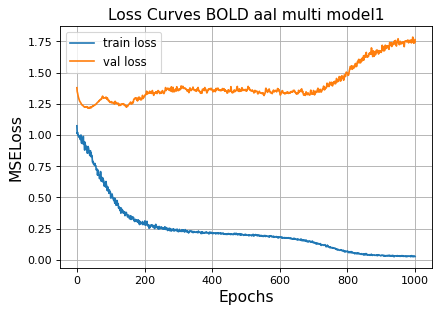

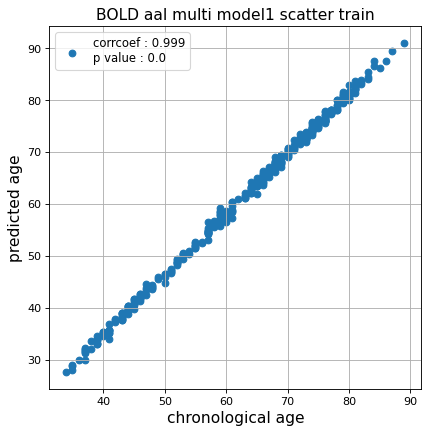

r^2 train data:  0.9605096055597038


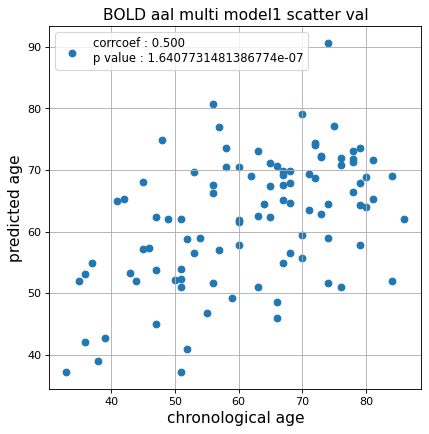

r^2 val data:  0.17348514830233996


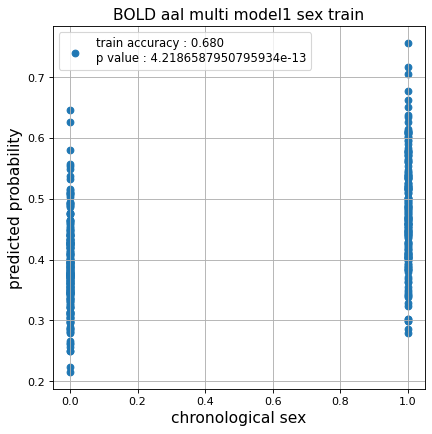

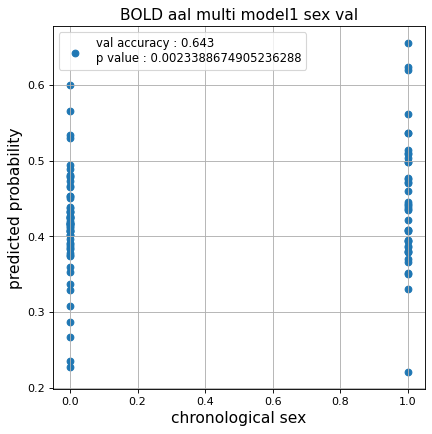

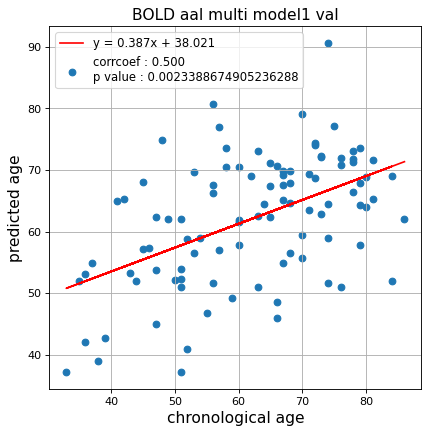

切片: 38.02089163914336
傾き: 0.3872517499956627
Kfold: 5 ::: epoch: 100, loss: 0.5031702426763681, val loss: 1.0146640837192535
Kfold: 5 ::: epoch: 200, loss: 0.2790501289642774, val loss: 0.9553886950016022
Kfold: 5 ::: epoch: 300, loss: 0.22833917347284463, val loss: 0.9498107433319092
Kfold: 5 ::: epoch: 400, loss: 0.20917666646150443, val loss: 0.9526480138301849
Kfold: 5 ::: epoch: 500, loss: 0.18848912303264326, val loss: 0.9281659722328186
Kfold: 5 ::: epoch: 600, loss: 0.13419047284584779, val loss: 0.9235525280237198
Kfold: 5 ::: epoch: 700, loss: 0.06830176510489903, val loss: 0.9923862367868423
Kfold: 5 ::: epoch: 800, loss: 0.038305993406818464, val loss: 1.1085832715034485
Kfold: 5 ::: epoch: 900, loss: 0.029805700939435225, val loss: 1.1399003118276596
Kfold: 5 ::: epoch: 1000, loss: 0.02487365070443887, val loss: 1.1427413374185562
save_epochs:462


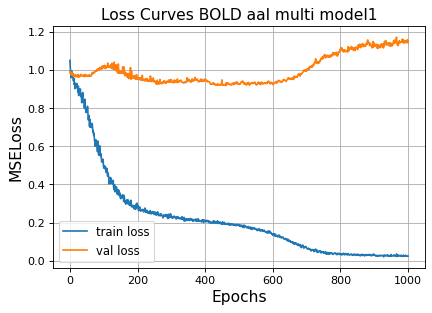

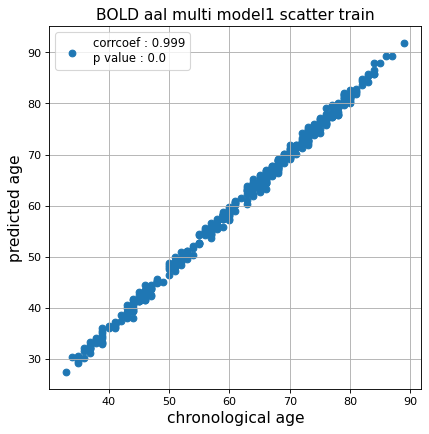

r^2 train data:  0.9699106150356485


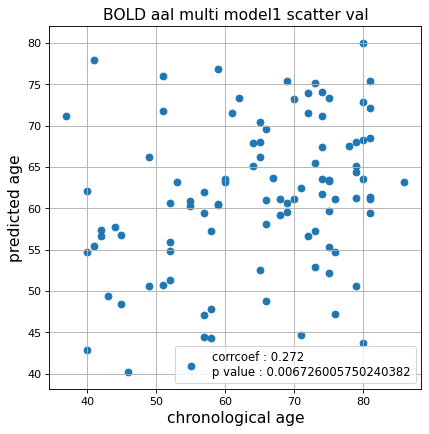

r^2 val data:  -0.17465276705984745


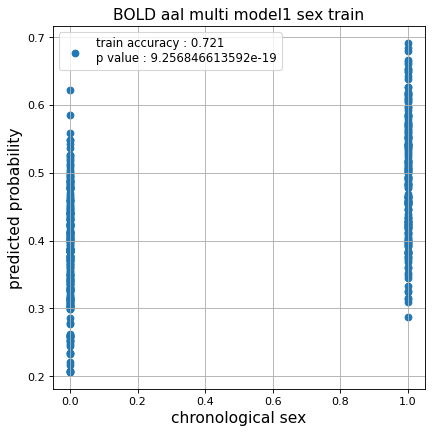

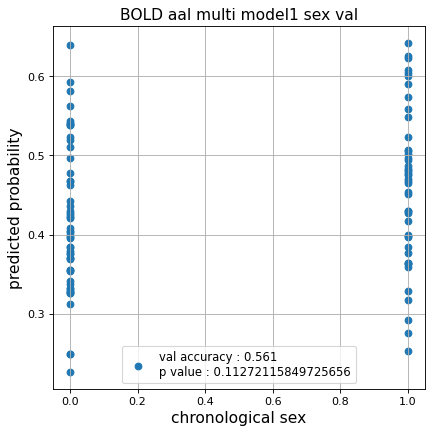

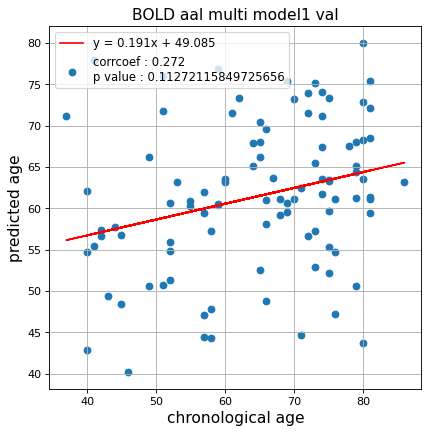

切片: 49.0851443640152
傾き: 0.19129897113875904
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.5454840981043302, val loss: 0.7937692552804947
Kfold: 1 ::: epoch: 200, loss: 0.28877362608909607, val loss: 0.776478499174118
Kfold: 1 ::: epoch: 300, loss: 0.22891520307614252, val loss: 0.7482499480247498
Kfold: 1 ::: epoch: 400, loss: 0.21092179188361534, val loss: 0.7286584377288818
Kfold: 1 ::: epoch: 500, loss: 0.20987550914287567, val loss: 0.6850876063108444
Kfold: 1 ::: epoch: 600, loss: 0.18267861008644104, val loss: 0.7047126591205597
Kfold: 1 ::: epoch: 700, loss: 0.1477403205174666, val loss: 0.6903120130300522
Kfold: 1 ::: epoch: 800, loss: 0.07317591200654323, val loss: 0.7369314283132553
Kfold: 1 ::: epoch: 900, loss: 0.03493361963102451, val loss: 0.8549192398786545
Kfold: 1 ::: epoch: 1000, loss: 0.02791199474953688, val loss: 0.9061980843544006
save_epochs:645


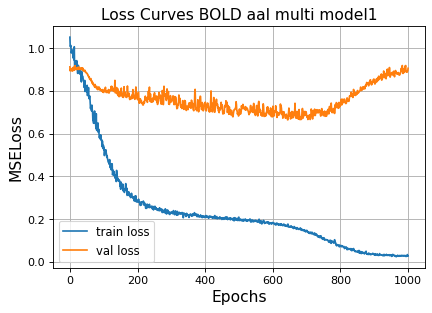

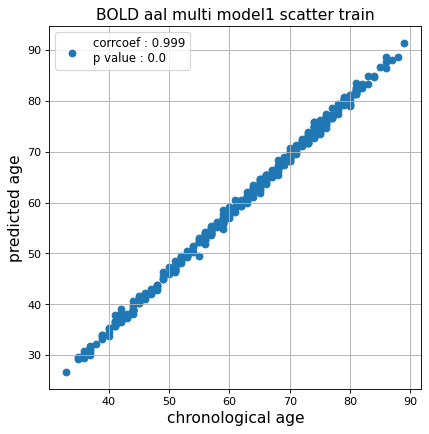

r^2 train data:  0.9564679963371465


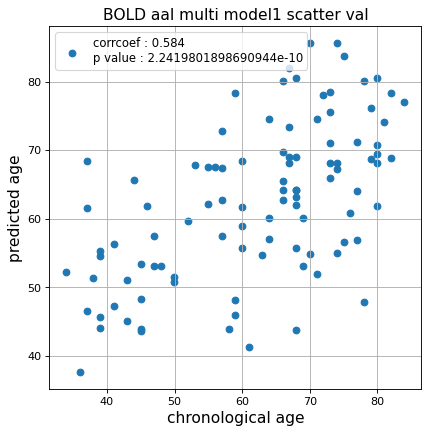

r^2 val data:  0.28049504644638357


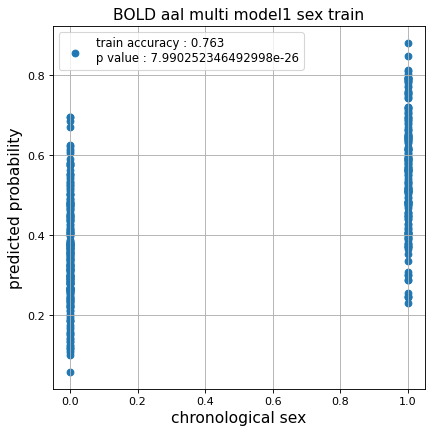

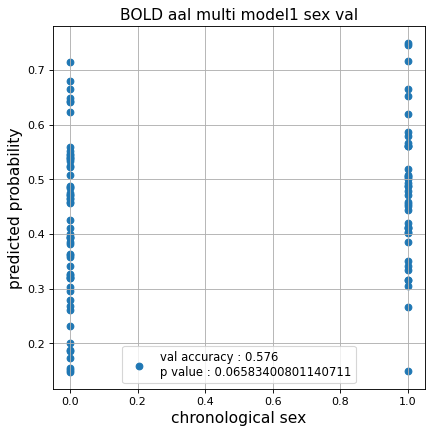

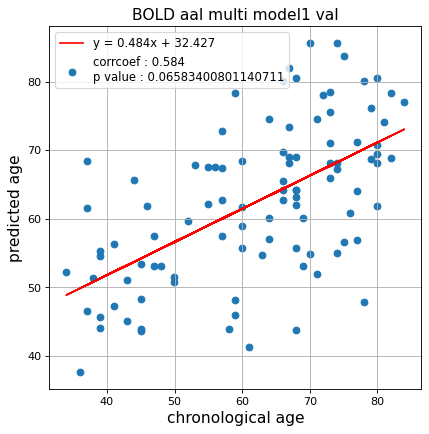

切片: 32.42656952950644
傾き: 0.4835197142715058
Kfold: 2 ::: epoch: 100, loss: 0.564305821290383, val loss: 0.8159740120172501
Kfold: 2 ::: epoch: 200, loss: 0.29792372309244597, val loss: 0.7826873958110809
Kfold: 2 ::: epoch: 300, loss: 0.24673106578680185, val loss: 0.7588170617818832
Kfold: 2 ::: epoch: 400, loss: 0.2276150377897116, val loss: 0.7386092841625214
Kfold: 2 ::: epoch: 500, loss: 0.20699904744441694, val loss: 0.7393524274230003
Kfold: 2 ::: epoch: 600, loss: 0.1815241391842182, val loss: 0.7301551848649979
Kfold: 2 ::: epoch: 700, loss: 0.1573380850828611, val loss: 0.71640944480896
Kfold: 2 ::: epoch: 800, loss: 0.08062826268948041, val loss: 0.7480880692601204
Kfold: 2 ::: epoch: 900, loss: 0.033632573313437976, val loss: 0.8470174372196198
Kfold: 2 ::: epoch: 1000, loss: 0.02967206410203989, val loss: 0.8817334398627281
save_epochs:725


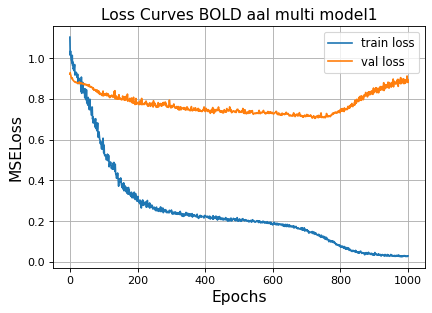

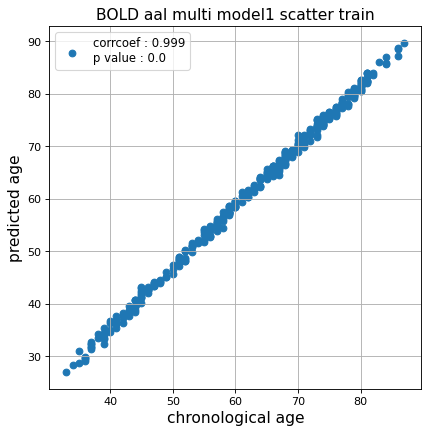

r^2 train data:  0.9672922956931935


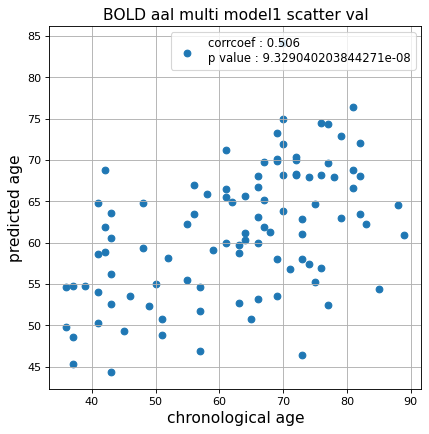

r^2 val data:  0.2452726142847106


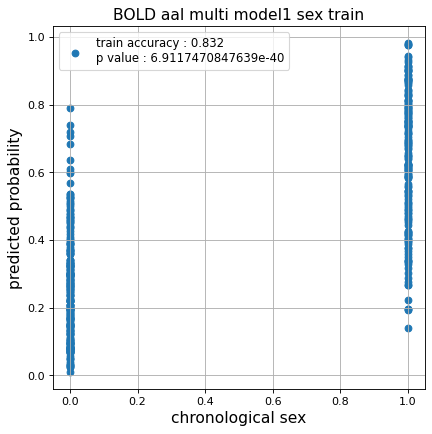

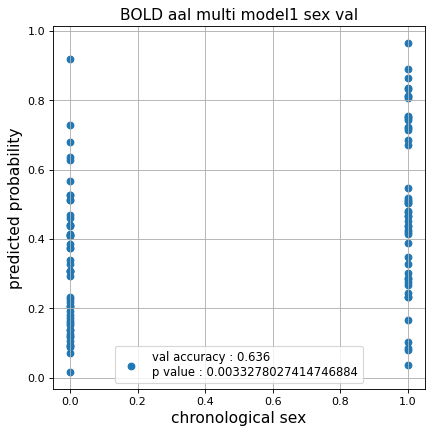

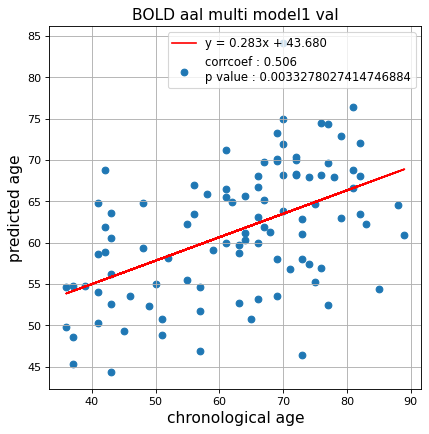

切片: 43.680253602070394
傾き: 0.2831797180764128
Kfold: 3 ::: epoch: 100, loss: 0.5946476642902081, val loss: 0.8499746024608612
Kfold: 3 ::: epoch: 200, loss: 0.3119733058489286, val loss: 0.8611594885587692
Kfold: 3 ::: epoch: 300, loss: 0.23351071774959564, val loss: 0.8345748335123062
Kfold: 3 ::: epoch: 400, loss: 0.21752472680348617, val loss: 0.8155298680067062
Kfold: 3 ::: epoch: 500, loss: 0.19931229605124548, val loss: 0.7973604947328568
Kfold: 3 ::: epoch: 600, loss: 0.16209706090963805, val loss: 0.8276758790016174
Kfold: 3 ::: epoch: 700, loss: 0.10607778280973434, val loss: 0.8651248812675476
Kfold: 3 ::: epoch: 800, loss: 0.04762292710634378, val loss: 0.9717717170715332
Kfold: 3 ::: epoch: 900, loss: 0.03322904385053194, val loss: 1.1039204746484756
Kfold: 3 ::: epoch: 1000, loss: 0.027128895601400964, val loss: 1.145805448293686
save_epochs:294


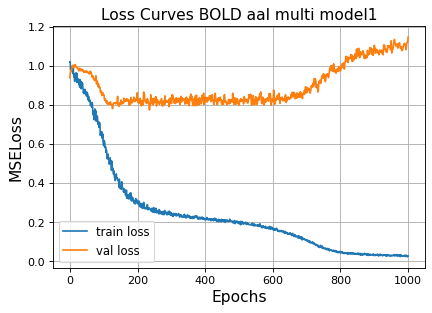

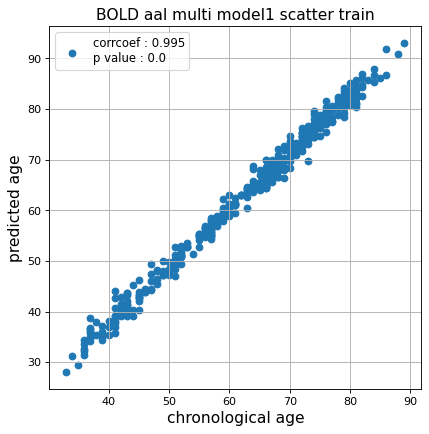

r^2 train data:  0.9724845288604923


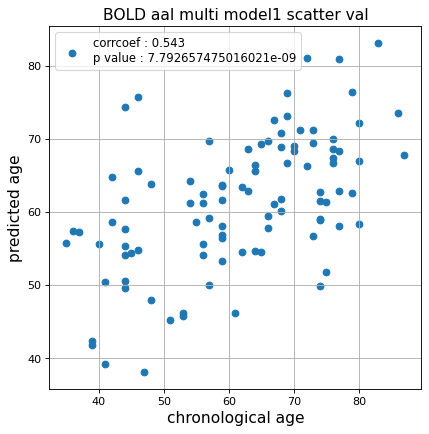

r^2 val data:  0.27152774014817005


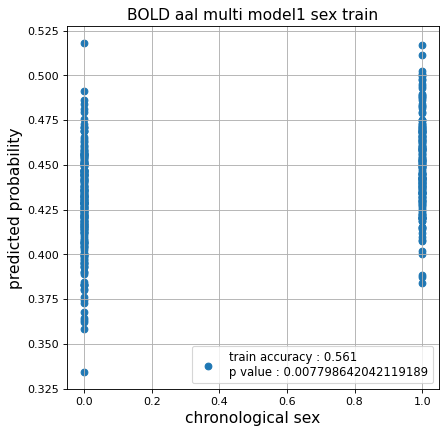

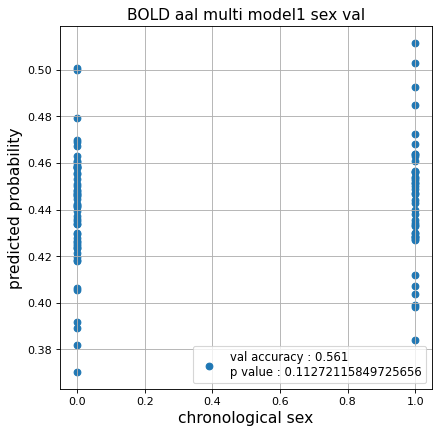

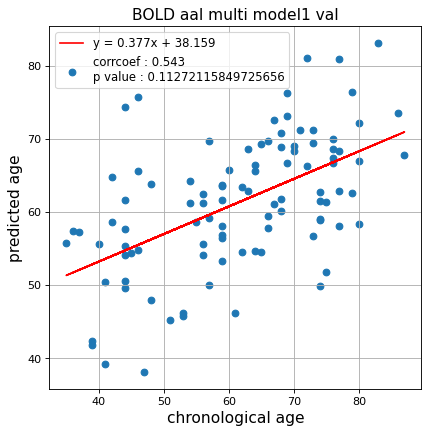

切片: 38.15854701088304
傾き: 0.3767390439434375
Kfold: 4 ::: epoch: 100, loss: 0.5709459598247821, val loss: 1.3679878264665604
Kfold: 4 ::: epoch: 200, loss: 0.2934406606050638, val loss: 1.3706211745738983
Kfold: 4 ::: epoch: 300, loss: 0.22767463555702797, val loss: 1.3397447317838669
Kfold: 4 ::: epoch: 400, loss: 0.2106538197168937, val loss: 1.3202828615903854
Kfold: 4 ::: epoch: 500, loss: 0.20192657525722796, val loss: 1.2691685855388641
Kfold: 4 ::: epoch: 600, loss: 0.1859889064843838, val loss: 1.2414332628250122
Kfold: 4 ::: epoch: 700, loss: 0.15791682096628043, val loss: 1.2220635563135147
Kfold: 4 ::: epoch: 800, loss: 0.0974910373871143, val loss: 1.2517612129449844
Kfold: 4 ::: epoch: 900, loss: 0.038671458999697976, val loss: 1.4243222177028656
Kfold: 4 ::: epoch: 1000, loss: 0.02822480759081932, val loss: 1.5219319760799408
save_epochs:732


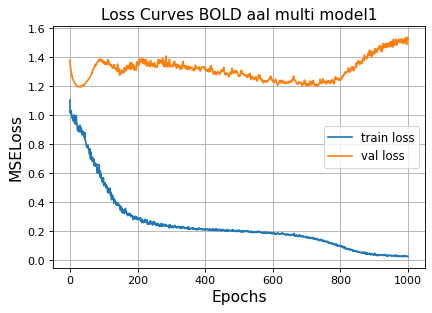

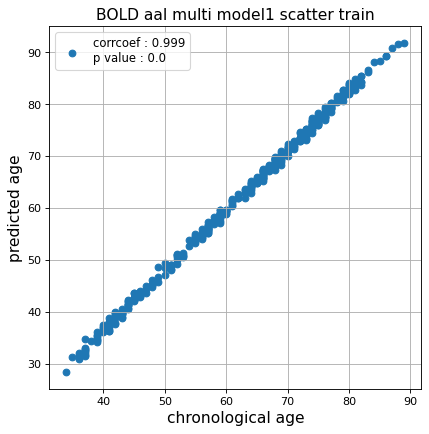

r^2 train data:  0.9721607776426309


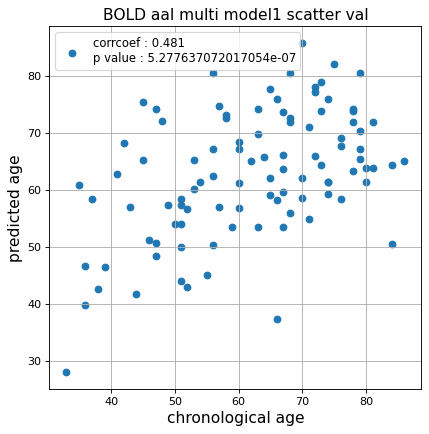

r^2 val data:  0.1086912155617471


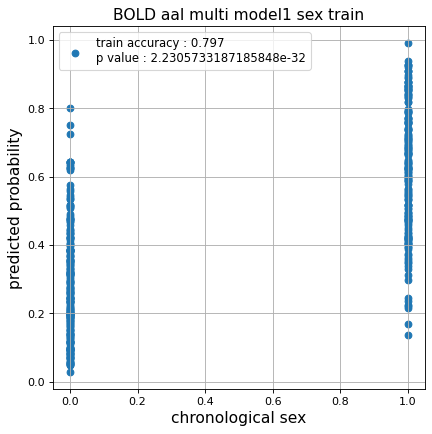

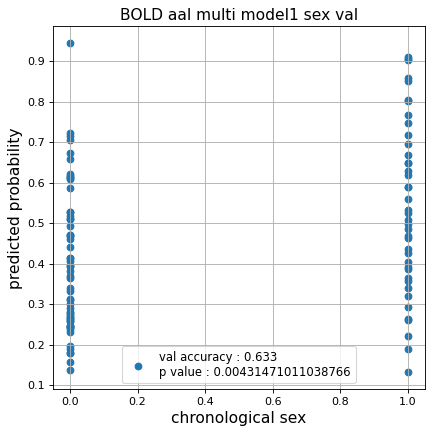

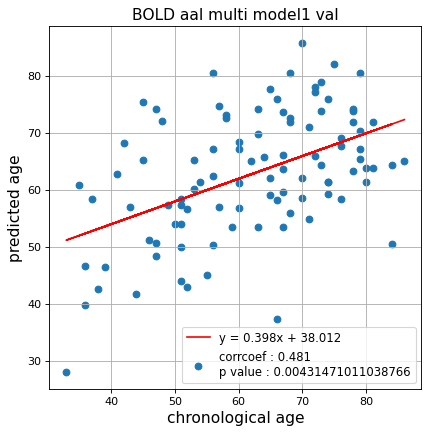

切片: 38.01159556335992
傾き: 0.3984218726376947
Kfold: 5 ::: epoch: 100, loss: 0.5311924196206607, val loss: 1.0145603567361832
Kfold: 5 ::: epoch: 200, loss: 0.28905793795218837, val loss: 0.9885854572057724
Kfold: 5 ::: epoch: 300, loss: 0.2387018375671827, val loss: 0.9792018383741379
Kfold: 5 ::: epoch: 400, loss: 0.21073372891316047, val loss: 0.9348916560411453
Kfold: 5 ::: epoch: 500, loss: 0.19656229477662307, val loss: 0.8939704149961472
Kfold: 5 ::: epoch: 600, loss: 0.1645092528599959, val loss: 0.8576565682888031
Kfold: 5 ::: epoch: 700, loss: 0.1102968047444637, val loss: 0.8785199970006943
Kfold: 5 ::: epoch: 800, loss: 0.045237679894153886, val loss: 1.0163209587335587
Kfold: 5 ::: epoch: 900, loss: 0.03042383076479802, val loss: 1.0868258327245712
Kfold: 5 ::: epoch: 1000, loss: 0.024738522604680978, val loss: 1.1503568291664124
save_epochs:662


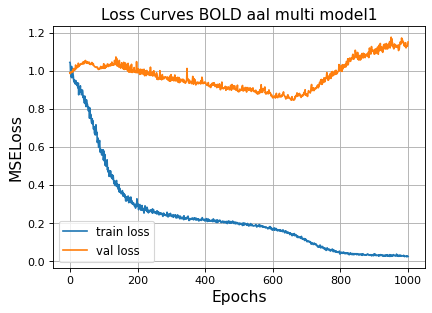

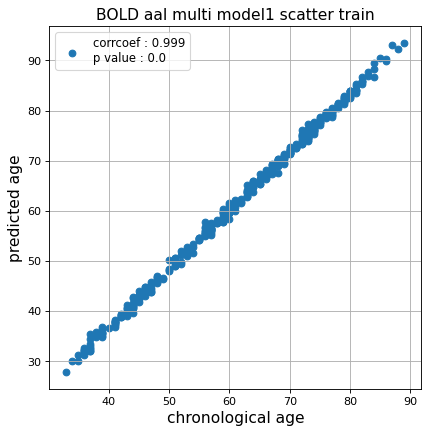

r^2 train data:  0.9677536782821947


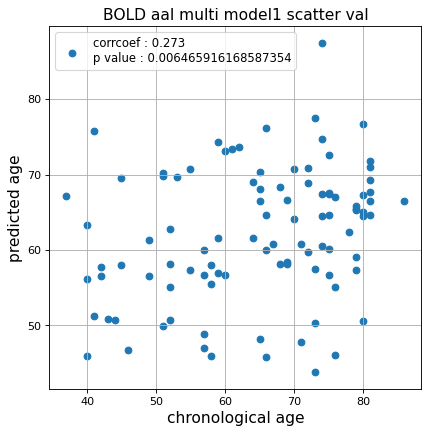

r^2 val data:  -0.13614907760452866


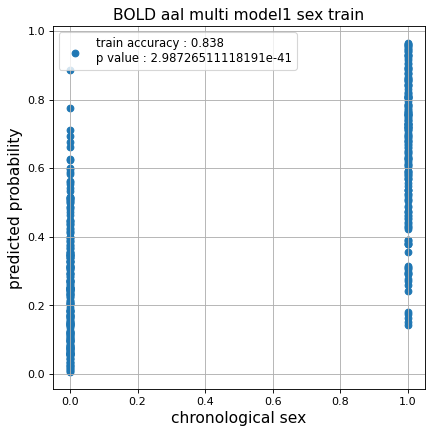

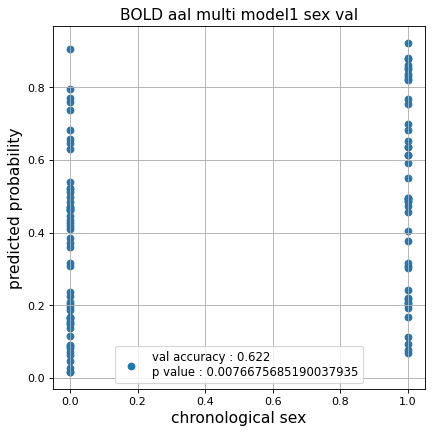

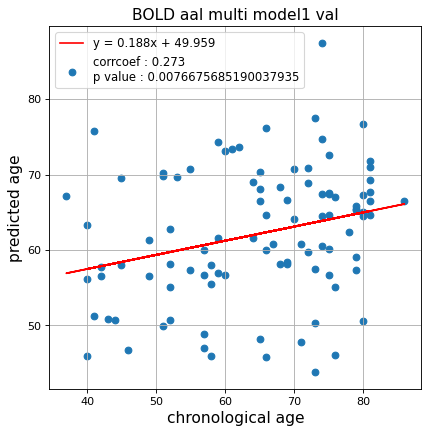

切片: 49.959495218116736
傾き: 0.18753020140403293
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.5643412722991064, val loss: 0.6873440444469452
Kfold: 1 ::: epoch: 200, loss: 0.27748429545989406, val loss: 0.7111373096704483
Kfold: 1 ::: epoch: 300, loss: 0.2342950518314655, val loss: 0.7078084796667099
Kfold: 1 ::: epoch: 400, loss: 0.21339735388755798, val loss: 0.7147173136472702
Kfold: 1 ::: epoch: 500, loss: 0.20383967459201813, val loss: 0.656286709010601
Kfold: 1 ::: epoch: 600, loss: 0.17533070880633134, val loss: 0.6818674206733704
Kfold: 1 ::: epoch: 700, loss: 0.13539293465706018, val loss: 0.6461361274123192
Kfold: 1 ::: epoch: 800, loss: 0.06199836874237427, val loss: 0.7259974926710129
Kfold: 1 ::: epoch: 900, loss: 0.03398218292456407, val loss: 0.856424555182457
Kfold: 1 ::: epoch: 1000, loss: 0.02887611621274398, val loss: 0.9058668315410614
save_epochs:637


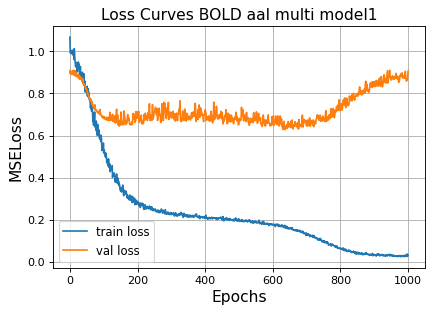

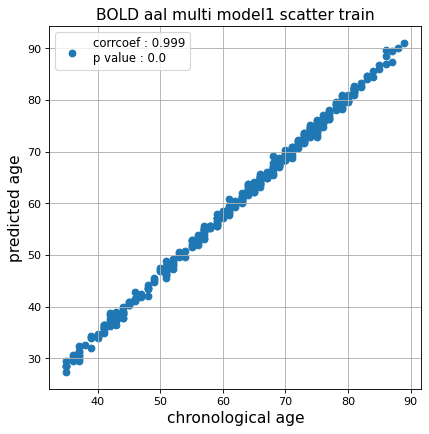

r^2 train data:  0.9527947667747063


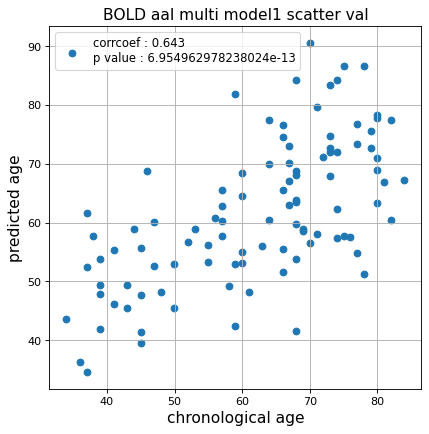

r^2 val data:  0.35049330400477496


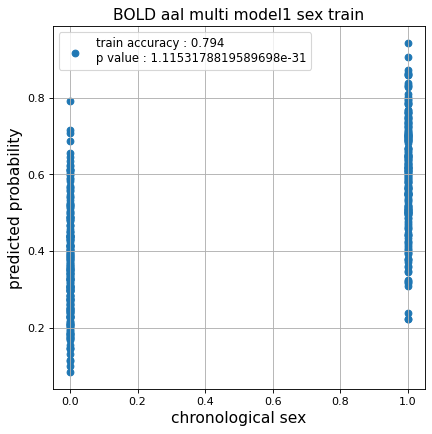

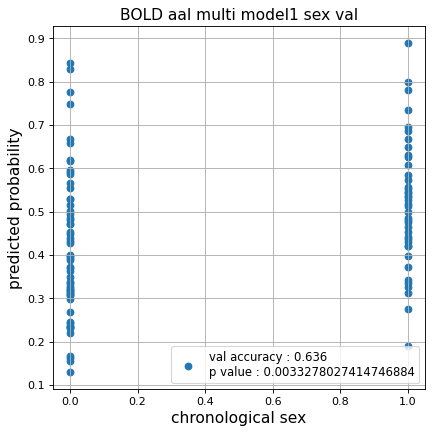

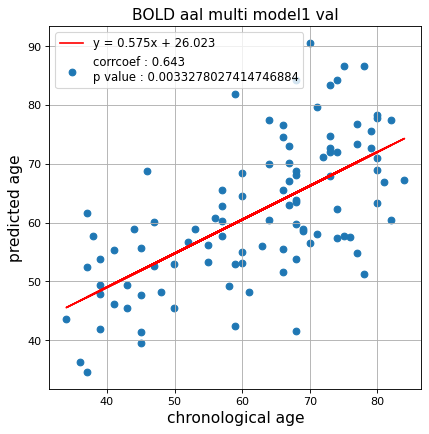

切片: 26.023492687947908
傾き: 0.5749287905534981
Kfold: 2 ::: epoch: 100, loss: 0.5600488575605246, val loss: 0.8060852959752083
Kfold: 2 ::: epoch: 200, loss: 0.2861564365717081, val loss: 0.7332190349698067
Kfold: 2 ::: epoch: 300, loss: 0.2489372961796247, val loss: 0.7074731066823006
Kfold: 2 ::: epoch: 400, loss: 0.21834449470043182, val loss: 0.689753919839859
Kfold: 2 ::: epoch: 500, loss: 0.19489841965528634, val loss: 0.6758959740400314
Kfold: 2 ::: epoch: 600, loss: 0.16997427894518927, val loss: 0.6595311798155308
Kfold: 2 ::: epoch: 700, loss: 0.12527125615340012, val loss: 0.6750323735177517
Kfold: 2 ::: epoch: 800, loss: 0.04989316801612194, val loss: 0.7787590101361275
Kfold: 2 ::: epoch: 900, loss: 0.029195998723690327, val loss: 0.8763715922832489
Kfold: 2 ::: epoch: 1000, loss: 0.029409900701676425, val loss: 0.8952401503920555
save_epochs:661


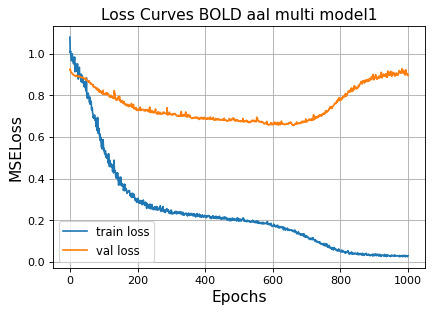

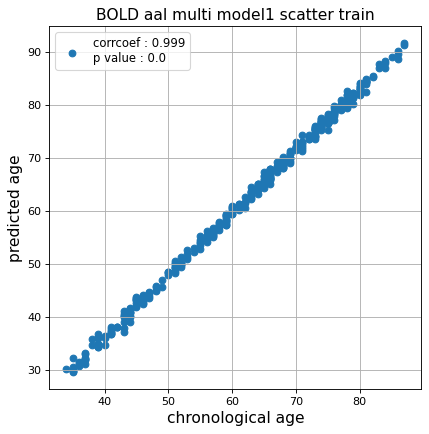

r^2 train data:  0.9668999426882351


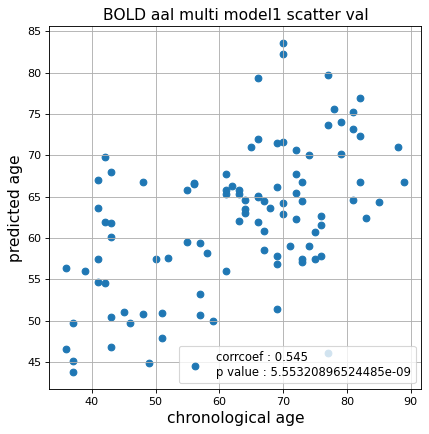

r^2 val data:  0.29186371798655


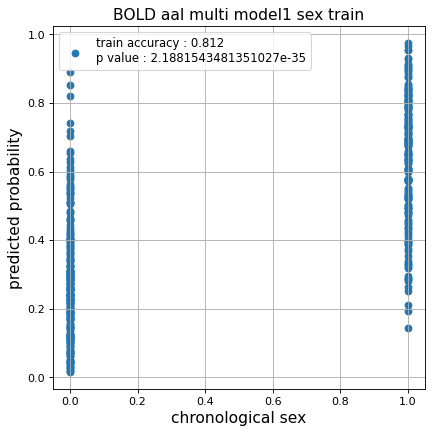

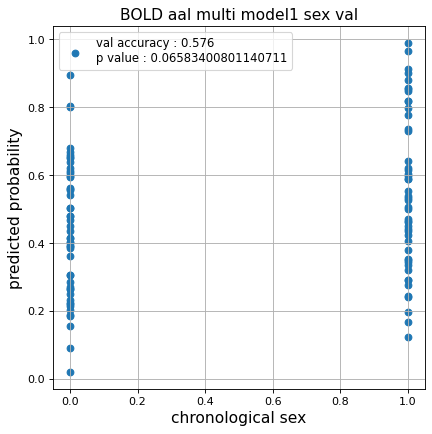

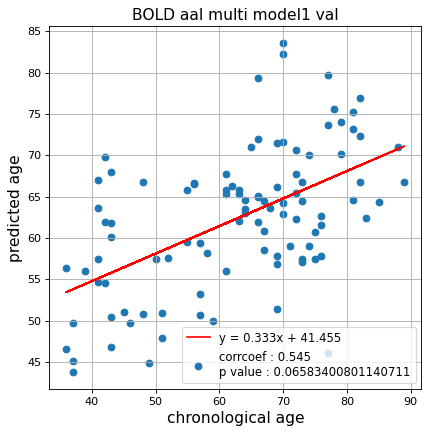

切片: 41.45512765799069
傾き: 0.3328810079193536
Kfold: 3 ::: epoch: 100, loss: 0.5972047264759357, val loss: 0.7727199494838715
Kfold: 3 ::: epoch: 200, loss: 0.3167037688768827, val loss: 0.7613806873559952
Kfold: 3 ::: epoch: 300, loss: 0.2396204242339501, val loss: 0.7034125328063965
Kfold: 3 ::: epoch: 400, loss: 0.2222512158063742, val loss: 0.6750050932168961
Kfold: 3 ::: epoch: 500, loss: 0.20273641783457536, val loss: 0.6520537212491035
Kfold: 3 ::: epoch: 600, loss: 0.17325772803563338, val loss: 0.6346600204706192
Kfold: 3 ::: epoch: 700, loss: 0.1228490276978566, val loss: 0.6574284359812737
Kfold: 3 ::: epoch: 800, loss: 0.0515988482019076, val loss: 0.7197675555944443
Kfold: 3 ::: epoch: 900, loss: 0.03140758823316831, val loss: 0.807526059448719
Kfold: 3 ::: epoch: 1000, loss: 0.030038036979161777, val loss: 0.8514213413000107
save_epochs:624


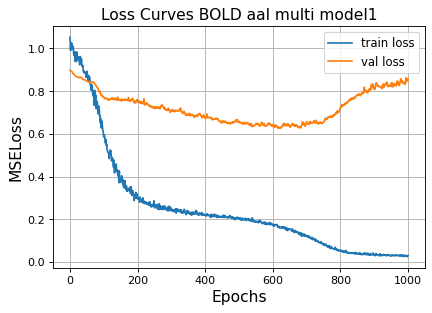

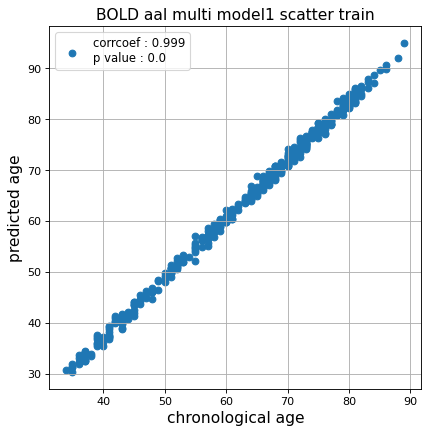

r^2 train data:  0.9671988316617031


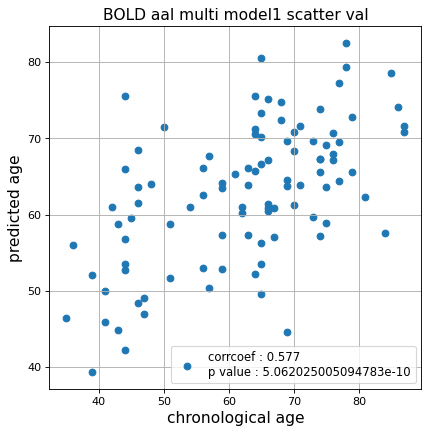

r^2 val data:  0.3176795029290378


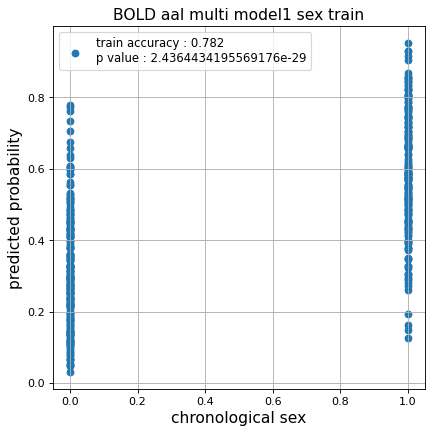

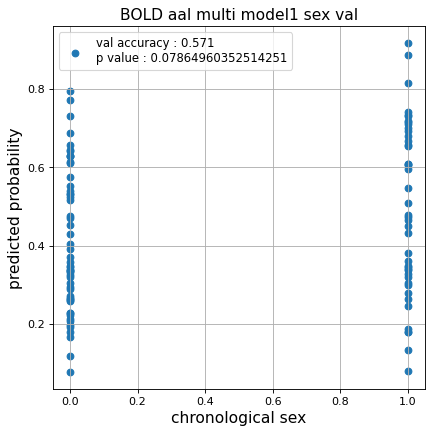

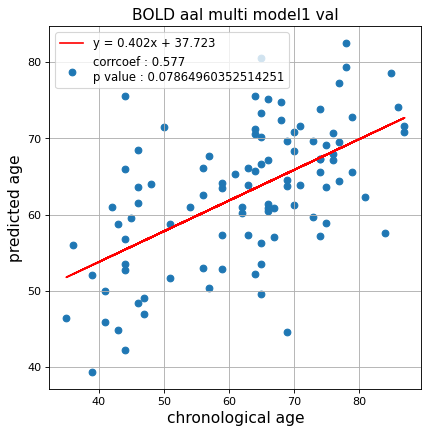

切片: 37.72335193466227
傾き: 0.4018182903500546
Kfold: 4 ::: epoch: 100, loss: 0.5617027213940253, val loss: 1.3390126079320908
Kfold: 4 ::: epoch: 200, loss: 0.29394293748415434, val loss: 1.3226059675216675
Kfold: 4 ::: epoch: 300, loss: 0.2235933645413472, val loss: 1.3060899674892426
Kfold: 4 ::: epoch: 400, loss: 0.20808939865002266, val loss: 1.2657326757907867
Kfold: 4 ::: epoch: 500, loss: 0.19983555376529694, val loss: 1.2321350574493408
Kfold: 4 ::: epoch: 600, loss: 0.18104095986256233, val loss: 1.1773018538951874
Kfold: 4 ::: epoch: 700, loss: 0.14200530258508828, val loss: 1.1443062871694565
Kfold: 4 ::: epoch: 800, loss: 0.07946336040130028, val loss: 1.188105285167694
Kfold: 4 ::: epoch: 900, loss: 0.03888776955696253, val loss: 1.3247003704309464
Kfold: 4 ::: epoch: 1000, loss: 0.02892174371159994, val loss: 1.413751170039177
save_epochs:738


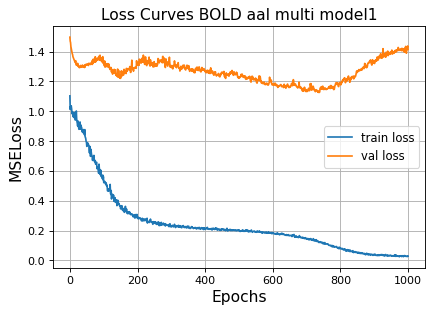

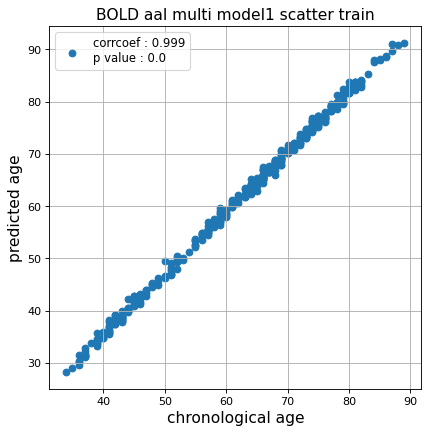

r^2 train data:  0.9674037344935112


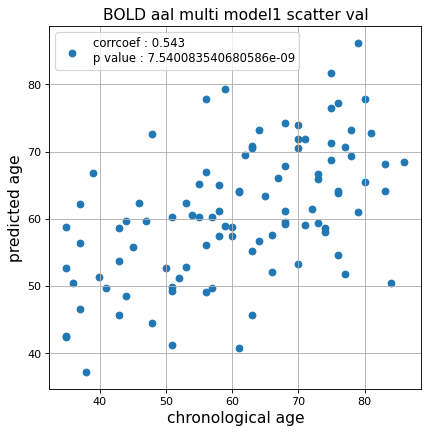

r^2 val data:  0.2658270310581925


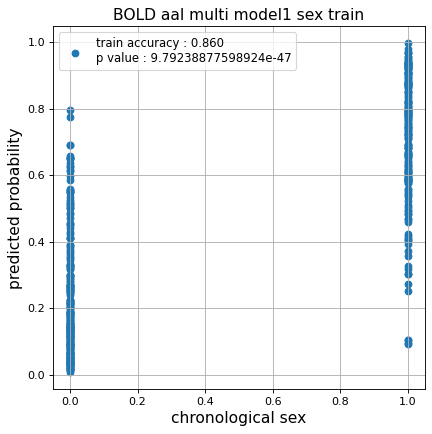

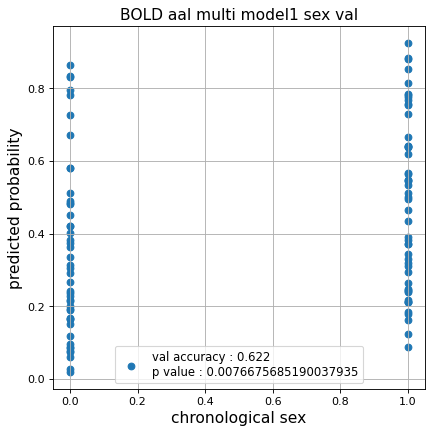

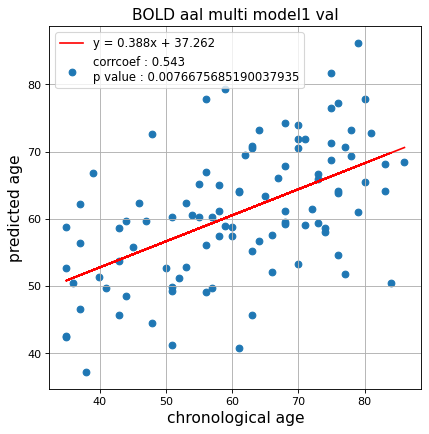

切片: 37.262172072929886
傾き: 0.38780347075131333
Kfold: 5 ::: epoch: 100, loss: 0.5338173325245197, val loss: 1.028722420334816
Kfold: 5 ::: epoch: 200, loss: 0.2831926162426288, val loss: 1.0005312860012054
Kfold: 5 ::: epoch: 300, loss: 0.23524233240347642, val loss: 0.9717814549803734
Kfold: 5 ::: epoch: 400, loss: 0.2051928284076544, val loss: 0.9295734092593193
Kfold: 5 ::: epoch: 500, loss: 0.1888471394777298, val loss: 0.9124376997351646
Kfold: 5 ::: epoch: 600, loss: 0.1538765739936095, val loss: 0.8970794752240181
Kfold: 5 ::: epoch: 700, loss: 0.09166609782439011, val loss: 0.9104855805635452
Kfold: 5 ::: epoch: 800, loss: 0.04269897250028757, val loss: 0.965824693441391
Kfold: 5 ::: epoch: 900, loss: 0.03008089501124162, val loss: 0.9993149116635323
Kfold: 5 ::: epoch: 1000, loss: 0.02598193560082179, val loss: 0.9989479519426823
save_epochs:647


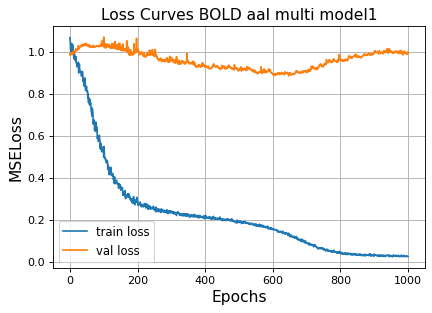

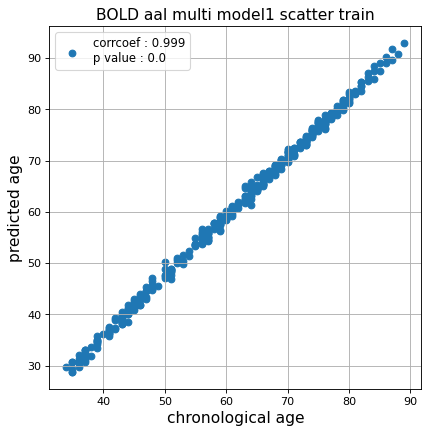

r^2 train data:  0.968765483726065


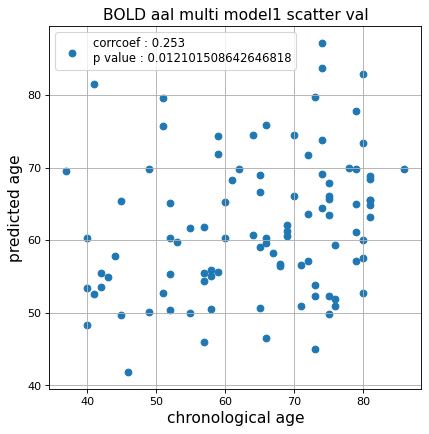

r^2 val data:  -0.22574432762421504


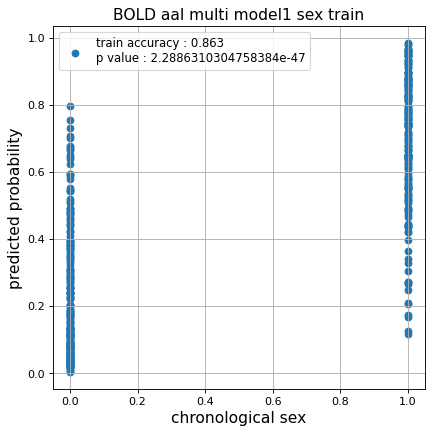

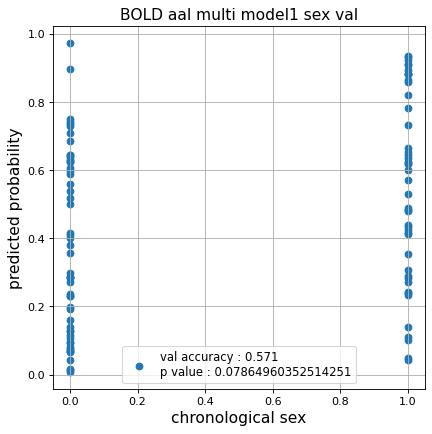

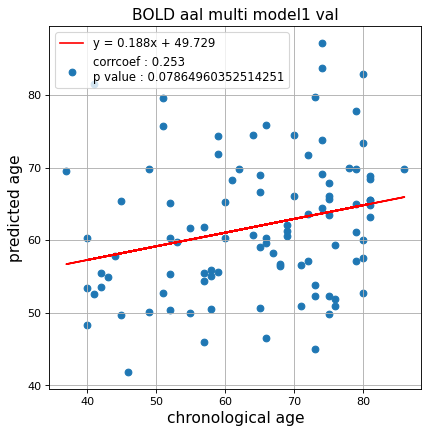

切片: 49.72894659476618
傾き: 0.1884010651533205
Nested Kfold ::: 5
Kfold: 1 ::: epoch: 100, loss: 0.5166611694372617, val loss: 0.7374115288257599
Kfold: 1 ::: epoch: 200, loss: 0.27644070524435777, val loss: 0.6818296909332275
Kfold: 1 ::: epoch: 300, loss: 0.23195593173687273, val loss: 0.6449166387319565
Kfold: 1 ::: epoch: 400, loss: 0.22206691595224234, val loss: 0.6432972699403763
Kfold: 1 ::: epoch: 500, loss: 0.20432539857350862, val loss: 0.6172648668289185
Kfold: 1 ::: epoch: 600, loss: 0.18055802927567408, val loss: 0.6232191622257233
Kfold: 1 ::: epoch: 700, loss: 0.15219316803492033, val loss: 0.6181198358535767
Kfold: 1 ::: epoch: 800, loss: 0.07440439640329434, val loss: 0.6472168266773224
Kfold: 1 ::: epoch: 900, loss: 0.03575067795239962, val loss: 0.7119736075401306
Kfold: 1 ::: epoch: 1000, loss: 0.024961981994028274, val loss: 0.7579754143953323
save_epochs:603


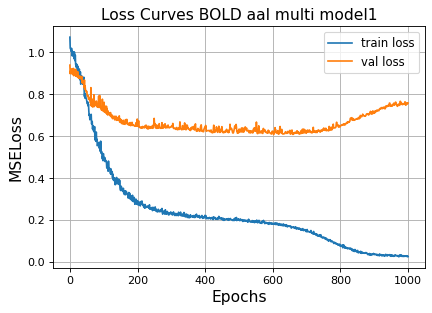

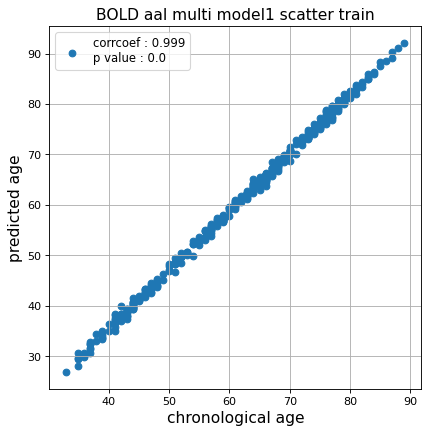

r^2 train data:  0.9675716399923489


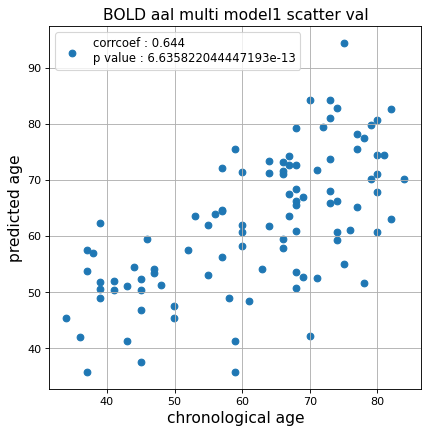

r^2 val data:  0.3544969502291955


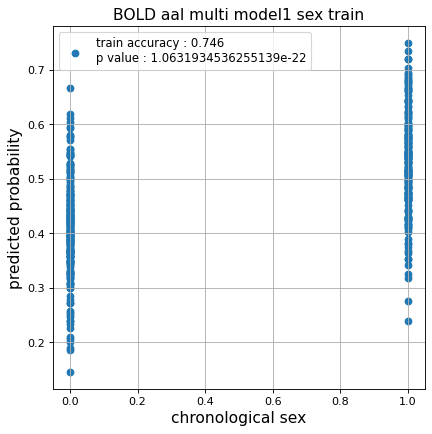

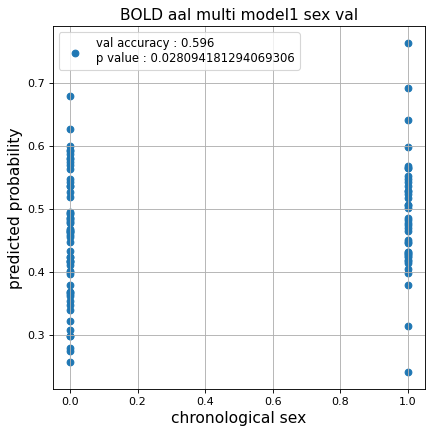

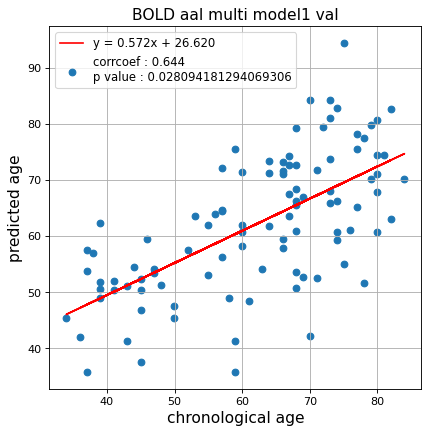

切片: 26.620355998909915
傾き: 0.571887103588355
Kfold: 2 ::: epoch: 100, loss: 0.5153088317467616, val loss: 0.7545227631926537


In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_all_1  = []
test_pred_aal_all_inverse_1  = []
test_label_aal_all_1 = []

test_idx_aal_all_1   = []
train_idx_aal_all_1  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1048,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'BOLD aal multi model1'
                                                          )
    
    test_pred_aal_all_1.append(test_pred)
    test_pred_aal_all_inverse_1.append(test_pred_inverse)
    test_label_aal_all_1.append(test_label)

    test_idx_aal_all_1.append(test_idx)
    train_idx_aal_all_1.append(train_idx)

### Bold 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_all_2  = []
test_pred_aal_all_inverse_2  = []
test_label_aal_all_2 = []

test_idx_aal_all_2   = []
train_idx_aal_all_2  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 750,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'BOLD aal multi model2'
                                                          )
    
    test_pred_aal_all_2.append(test_pred)
    test_pred_aal_all_inverse_2.append(test_pred_inverse)
    test_label_aal_all_2.append(test_label)

    test_idx_aal_all_2.append(test_idx)
    train_idx_aal_all_2.append(train_idx)

### データ保存

In [ ]:
np.savez('../02_data_analysis/temp/all_multi_aal_1',
         test_pred_aal_all_1,
         test_pred_aal_all_inverse_1,
         test_label_aal_all_1,
         test_idx_aal_all_1,
         train_idx_aal_all_1)
np.savez('../02_data_analysis/temp/all_multi_aal_2',
         test_pred_aal_all_2,
         test_pred_aal_all_inverse_2,
         test_label_aal_all_2,
         test_idx_aal_all_2,
         train_idx_aal_all_2)

### Data定義(dynamic FC)

In [ ]:
%%time
df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
data_dynamic_aal = make_data(df_dynamic_aal)
print(data_dynamic_aal.shape)

### Dynamic FC 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_all_dynamic_1  = []
test_pred_aal_all_dynamic_inverse_1  = []
test_label_aal_all_dynamic_1 = []

test_idx_aal_all_dynamic_1   = []
train_idx_aal_all_dynamic_1  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 750,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal multi model1'
                                                          )
    
    test_pred_aal_all_dynamic_1.append(test_pred)
    test_pred_aal_all_dynamic_inverse_1.append(test_pred_inverse)
    test_label_aal_all_dynamic_1.append(test_label)

    test_idx_aal_all_dynamic_1.append(test_idx)
    train_idx_aal_all_dynamic_1.append(train_idx)

### Dynamic FC 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_all_dynamic_2  = []
test_pred_aal_all_dynamic_inverse_2  = []
test_label_aal_all_dynamic_2 = []

test_idx_aal_all_dynamic_2   = []
train_idx_aal_all_dynamic_2  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 750,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal multi model2'
                                                          )
    
    test_pred_aal_all_dynamic_2.append(test_pred)
    test_pred_aal_all_dynamic_inverse_2.append(test_pred_inverse)
    test_label_aal_all_dynamic_2.append(test_label)

    test_idx_aal_all_dynamic_2.append(test_idx)
    train_idx_aal_all_dynamic_2.append(train_idx)

### データ保存

In [ ]:
np.savez('../02_data_analysis/temp/all_multi_dynamic_aal_1',
         test_pred_aal_all_dynamic_1,
         test_pred_aal_all_dynamic_inverse_1,
         test_label_aal_all_dynamic_1,
         test_idx_aal_all_dynamic_1,
         train_idx_aal_all_dynamic_1)
np.savez('../02_data_analysis/temp/all_multi_dynamic_aal_2',
         test_pred_aal_all_dynamic_2,
         test_pred_aal_all_dynamic_inverse_2,
         test_label_aal_all_dynamic_2,
         test_idx_aal_all_dynamic_2,
         train_idx_aal_all_dynamic_2)

## 学習(Harvard-Oxford)

### Bold 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_all_1  = []
test_pred_ho_all_inverse_1  = []
test_label_ho_all_1 = []

test_idx_ho_all_1   = []
train_idx_ho_all_1  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 750,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1048,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'BOLD ho multi model1'
                                                          )
    
    test_pred_ho_all_1.append(test_pred)
    test_pred_ho_all_inverse_1.append(test_pred_inverse)
    test_label_ho_all_1.append(test_label)

    test_idx_ho_all_1.append(test_idx)
    train_idx_ho_all_1.append(train_idx)

### Bold 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_all_2  = []
test_pred_ho_all_inverse_2  = []
test_label_ho_all_2 = []

test_idx_ho_all_2   = []
train_idx_ho_all_2  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 750,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'BOLD ho multi model2'
                                                          )
    
    test_pred_ho_all_2.append(test_pred)
    test_pred_ho_all_inverse_2.append(test_pred_inverse)
    test_label_ho_all_2.append(test_label)

    test_idx_ho_all_2.append(test_idx)
    train_idx_ho_all_2.append(train_idx)

### データ保存

In [ ]:
np.savez('../02_data_analysis/temp/all_multi_ho_1',
         test_pred_ho_all_1,
         test_pred_ho_all_inverse_1,
         test_label_ho_all_1,
         test_idx_ho_all_1,
         train_idx_ho_all_1)
np.savez('../02_data_analysis/temp/all_multi_ho_2',
         test_pred_ho_all_2,
         test_pred_ho_all_inverse_2,
         test_label_ho_all_2,
         test_idx_ho_all_2,
         train_idx_ho_all_2)

### Data定義(dynamic FC)

In [ ]:
%%time
df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')
data_dynamic_ho = make_data(df_dynamic_ho)
print(data_dynamic_ho.shape)

### Dynamic FC 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_all_dynamic_1  = []
test_pred_ho_all_dynamic_inverse_1  = []
test_label_ho_all_dynamic_1 = []

test_idx_ho_all_dynamic_1   = []
train_idx_ho_all_dynamic_1  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 750,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho multi model1'
                                                          )
    
    test_pred_ho_all_dynamic_1.append(test_pred)
    test_pred_ho_all_dynamic_inverse_1.append(test_pred_inverse)
    test_label_ho_all_dynamic_1.append(test_label)

    test_idx_ho_all_dynamic_1.append(test_idx)
    train_idx_ho_all_dynamic_1.append(train_idx)

### Dynamic FC 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_all_dynamic_2  = []
test_pred_ho_all_dynamic_inverse_2  = []
test_label_ho_all_dynamic_2 = []

test_idx_ho_all_dynamic_2   = []
train_idx_ho_all_dynamic_2  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_inverse,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 750,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho multi model2'
                                                          )
    
    test_pred_ho_all_dynamic_2.append(test_pred)
    test_pred_ho_all_dynamic_inverse_2.append(test_pred_inverse)
    test_label_ho_all_dynamic_2.append(test_label)

    test_idx_ho_all_dynamic_2.append(test_idx)
    train_idx_ho_all_dynamic_2.append(train_idx)

### データ保存

In [ ]:
np.savez('../02_data_analysis/temp/all_multi_dynamic_ho_1',
         test_pred_ho_all_dynamic_1,
         test_pred_ho_all_dynamic_inverse_1,
         test_label_ho_all_dynamic_1,
         test_idx_ho_all_dynamic_1,
         train_idx_ho_all_dynamic_1)
np.savez('../02_data_analysis/temp/all_multi_dynamic_ho_2',
         test_pred_ho_all_dynamic_2,
         test_pred_ho_all_dynamic_inverse_2,
         test_label_ho_all_dynamic_2,
         test_idx_ho_all_dynamic_2,
         train_idx_ho_all_dynamic_2)